## PCA on Handwritten Digits

PCA is a dimensionality reduction techinique, i.e. it doesn't use the outputs. <br>
<b>Goal: Projection of input vector X to a reduced input vector Y usiing a projection matrix: P. </b><br>
The construction of the projection matrix is based on a maximization problem: maximizing the variance explained by each principal component.

In [16]:
# Basic Numeral Libraries
import numpy as np
import pandas as pd

# Standard Data Analysis Library and Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Functions
import os, re
from pprint import pprint
import random
from tqdm import tqdm

# SkLearn Modules and Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import eigh
from matplotlib.font_manager import FontProperties

### Loading MNIST Dataset

In [2]:
# Dataset Files Locations
train_dataset_loc = './Nepali Dataset/train_digits_data.csv'
test_dataset_loc = './Nepali Dataset/test_digits_data.csv'

train_df = pd.read_csv(train_dataset_loc)
test_df = pd.read_csv(test_dataset_loc)

#### Combining both MNIST train.csv and test.csv into Train Dataset

In [3]:
# Combining both Train & Test MNIST CSV Dataset 
train_dataset = pd.concat([train_df, test_df], axis = 0, ignore_index = True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 8)
train_dataset.head(10)

pixel_0000  pixel_0001  pixel_0002  pixel_0003  ...  pixel_1021  \
0           0           0           0           0  ...           0   
1           0           0           0           0  ...           0   
2           0           0           0           0  ...           0   
3           0           0           0           0  ...           0   
4           0           0           0           0  ...           0   
5           0           0           0           0  ...           0   
6           0           0           0           0  ...           0   
7           0           0           0           0  ...           0   
8           0           0           0           0  ...           0   
9           0           0           0           0  ...           0   

   pixel_1022  pixel_1023  character  
0           0           0    digit_0  
1           0           0    digit_0  
2           0           0    digit_0  
3           0           0    digit_0  
4           0           0    digit_0  
5           0           0    digit_0  
6           0           0    digit_0  
7           0           0    digit_0  
8           0           0    digit_0  
9           0           0    digit_0  

[10 rows x 1025 columns]

#### Separating Label and Pixel Features

In [4]:
X_train_input, y_train_target = train_dataset.iloc[:, :-1], train_dataset.iloc[:, -1]
print(f"X_INPUT Shape: {X_train_input.shape}")
print(f"y_TARGET Shape: {y_train_target.shape}")
y_train_target.head(3)

X_INPUT Shape: (20000, 1024)
y_TARGET Shape: (20000,)


0    digit_0
1    digit_0
2    digit_0
Name: character, dtype: object

#### Dataset Sample Visualization

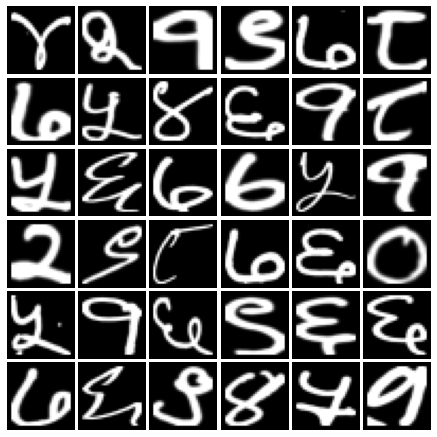

In [5]:
plt.figure(figsize = (6, 6))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.05)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    rand_index = random.randint(0, len(X_train_input))
    rand_img = X_train_input.iloc[rand_index].to_numpy().reshape(32, 32)
    plt.imshow(rand_img, cmap = 'gray')
    plt.axis('off')
plt.show()
#plt.savefig('digits.png')

### Normalizing Pixels Featurs (X_train_input)
NOTE: While using StandardScaler(), if you have separate training and test datasets, it's important to fit the scaler only on the training data and then use the same scaler to transform the test data. This ensures that the scaling is consistent across both datasets.

#### Using StandardScaler() function

In [6]:
scaler_X = StandardScaler()
scaled_X_train_1 = scaler_X.fit_transform(X_train_input)

#### Using Manual functions

In [7]:
mean = np.mean(X_train_input, axis = 0)
std = np.std(X_train_input, axis = 0)
scaled_X_train_2 = ((X_train_input - mean) / std).values
scaled_X_train_2 = np.nan_to_num(scaled_X_train_2, nan = 0)

In [8]:
np.sum((scaled_X_train_1 - scaled_X_train_2) ** 2)

1.0257004053812674e-19

In [9]:
scaled_X_train = scaled_X_train_1

Since, the squared distance between two scaled_X_train from StandardScaler() and Manual method is nearly equal to zero. So, I conclude that both method yields same operation output.

#### PCA: 
- Find Covariance Matrix of the Input Data
- Plot and Analyze the Covariance Matrix
- Goal: The covariance matrix should have principal diagonal elements maximum and non-diagonal elements nearly zero

#### Comparing Covariance Calculation between np.cov() and Manual method <br>

In [10]:
# Using np.cov() function from Numpy
X_cov = np.cov((X_train_input-mean).T)

In [11]:
manual_X_cov = ((X_train_input - mean).T @ (X_train_input)) / (X_train_input.shape[0] - 1)

In [12]:
np.sum(np.sum((X_cov - manual_X_cov) ** 2))

5.769671840799202e-18

Again, on comparing manual Covariance Matrix and np.cov() method, both gave results whose distance seems little to zero. <br>
NOTE: <b> But, the covariance is actually taken for (X_train_input - mean) / std i.e. output from StandardScaler() or onscaled_X_train </b>

In [13]:
X_cov = np.cov(scaled_X_train.T)

In [17]:
font = FontProperties(family='Arial', size=12)

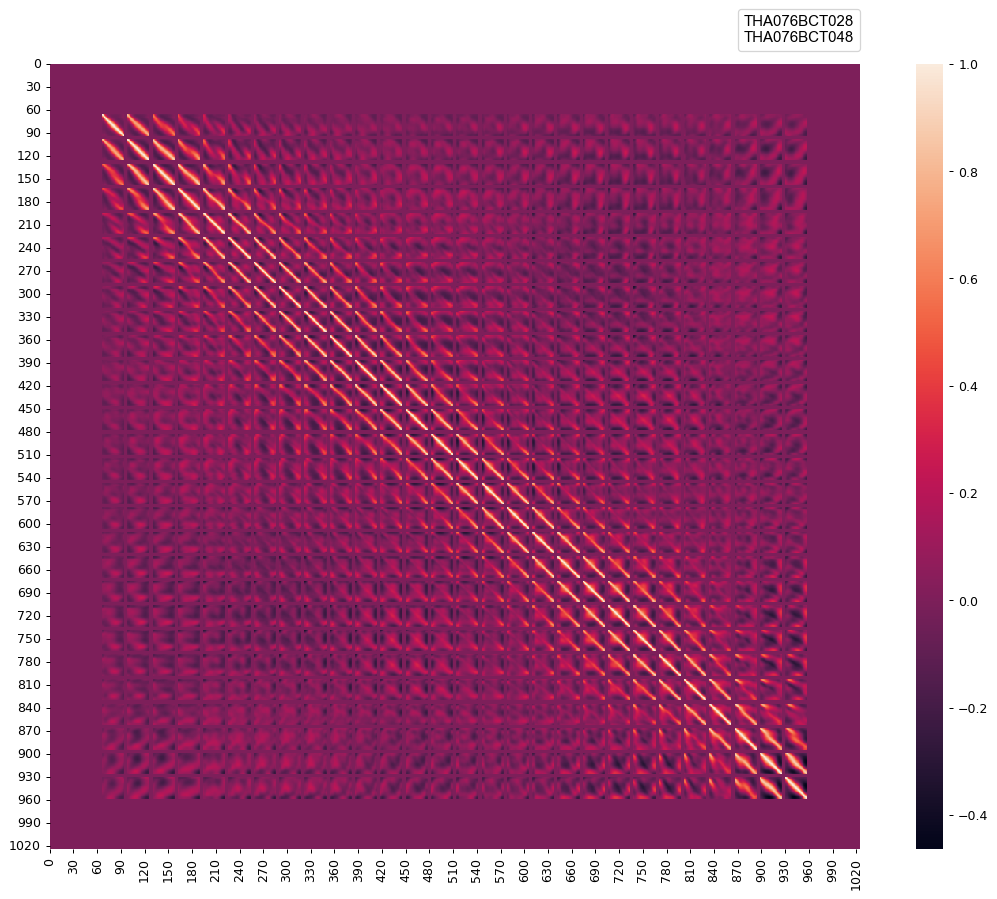

In [47]:
plt.figure(figsize=(12, 10), dpi = 90)
ax = sns.heatmap(pd.DataFrame(X_cov), annot = False)
plt.tick_params(axis='both', which='both', labelsize = 10)
legend_1 = plt.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font)
legend_1.set_bbox_to_anchor((1.010, 1.08))

# Increase the gap between the heatmap and the colorbar using the shrink parameter
cbar = ax.collections[0].colorbar
cbar.ax.set_aspect(20)  # Adjust the value as needed to increase the gap

sparse_ticks = range(0, len(X_cov), 30)
sparse_tick_labels = range(0, len(X_cov), 30)
plt.xticks(sparse_ticks, sparse_tick_labels)
plt.yticks(sparse_ticks, sparse_tick_labels)

plt.savefig('./Figures/Input Covariance Matrix.png', dpi = 300, bbox_inches = 'tight')

plt.tight_layout()
plt.show()

#### Analysis: (UJJWAL MAKE AMENDS)
1. The higher values along the principal diagonal shows that the given input data has larger variance in a particular direction and perpendicular to it, the variance is low.
2. The objective is to find a matrix Y such that the transformation of input data X, will give a covariance on Y such that the elements on the principal diagonal is maximum and elsewhere nearly zero.
3. This might mean that the given MNIST data has some pattern, which could be leveraged to get the prominent features and suppress the noises or in simple terms, PCA can be applied to this to get better data representation.

### Eigenvectors and Eigenvalues of Covariance Matrix

In [49]:
#Note: Eigenvalues aren't necessarily sorted, but eigenvalues[i] 'DOES' correspond to eigenvectors.T[i]
eigenvalues_1, eigenvectors = np.linalg.eig(X_cov) 

print(f"Eigenvalues Shape: {eigenvalues_1.shape}")
print(f"Eigenvectors Shape: {eigenvectors.shape}")

Eigenvalues Shape: (1024,)
Eigenvectors Shape: (1024, 1024)


In [50]:
eigenvalues, eigenvectors = eigh(X_cov)

In [51]:
cosine_similarity(eigenvalues_1.reshape(1, -1), eigenvalues.reshape(1, -1))

array([[1.42490316e-05]])

On assessing different functions for calculating eigenvalues, we found that the np.linalg.eig(X_cov) given negavtive eigenvalues with clipping effect for less than 1e-17. So, scipy.linalg.eigh(X_cov) is used whose value is similar to 'explained_variance_' from sklearn PCA, but still this shows some clipping effect, which has been down.<br>
Also, the cosine similarity between the eigenvalues from np.linalg.eigh() and scipy.linalg.eigh() shows that they are highly dissimilar, but at the same time the similarity score between eigenvalues from np.linalg.eigh() and from sklearn_PCA.explained_variance_ is 1.0 (High).

NOTE: The Eigenvectors are column-wise expressed from above np.linalg.eig(X_cov).

#### Unhealthy implementation of sorting eigenvalues and eigenvectors. 

In [52]:
# Unsorted tuple of (eigenvalues[i], eigenvectors[i])
unsorted_eigen_value_vector = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]

# Sorting tuple by eigenvalues
eigen_values_vectors = sorted(unsorted_eigen_value_vector, reverse = True, key = lambda x : x[0])

#### Smart way to sort eigenvalues and eigenvectors.
In this implemention, the eigenvectors are transposed i.e. row-wise eigenvector representation.

In [53]:
sorted_idxs = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues = np.abs(eigenvalues)[sorted_idxs]
eigenvectors = eigenvectors.T[sorted_idxs] # The transposed act

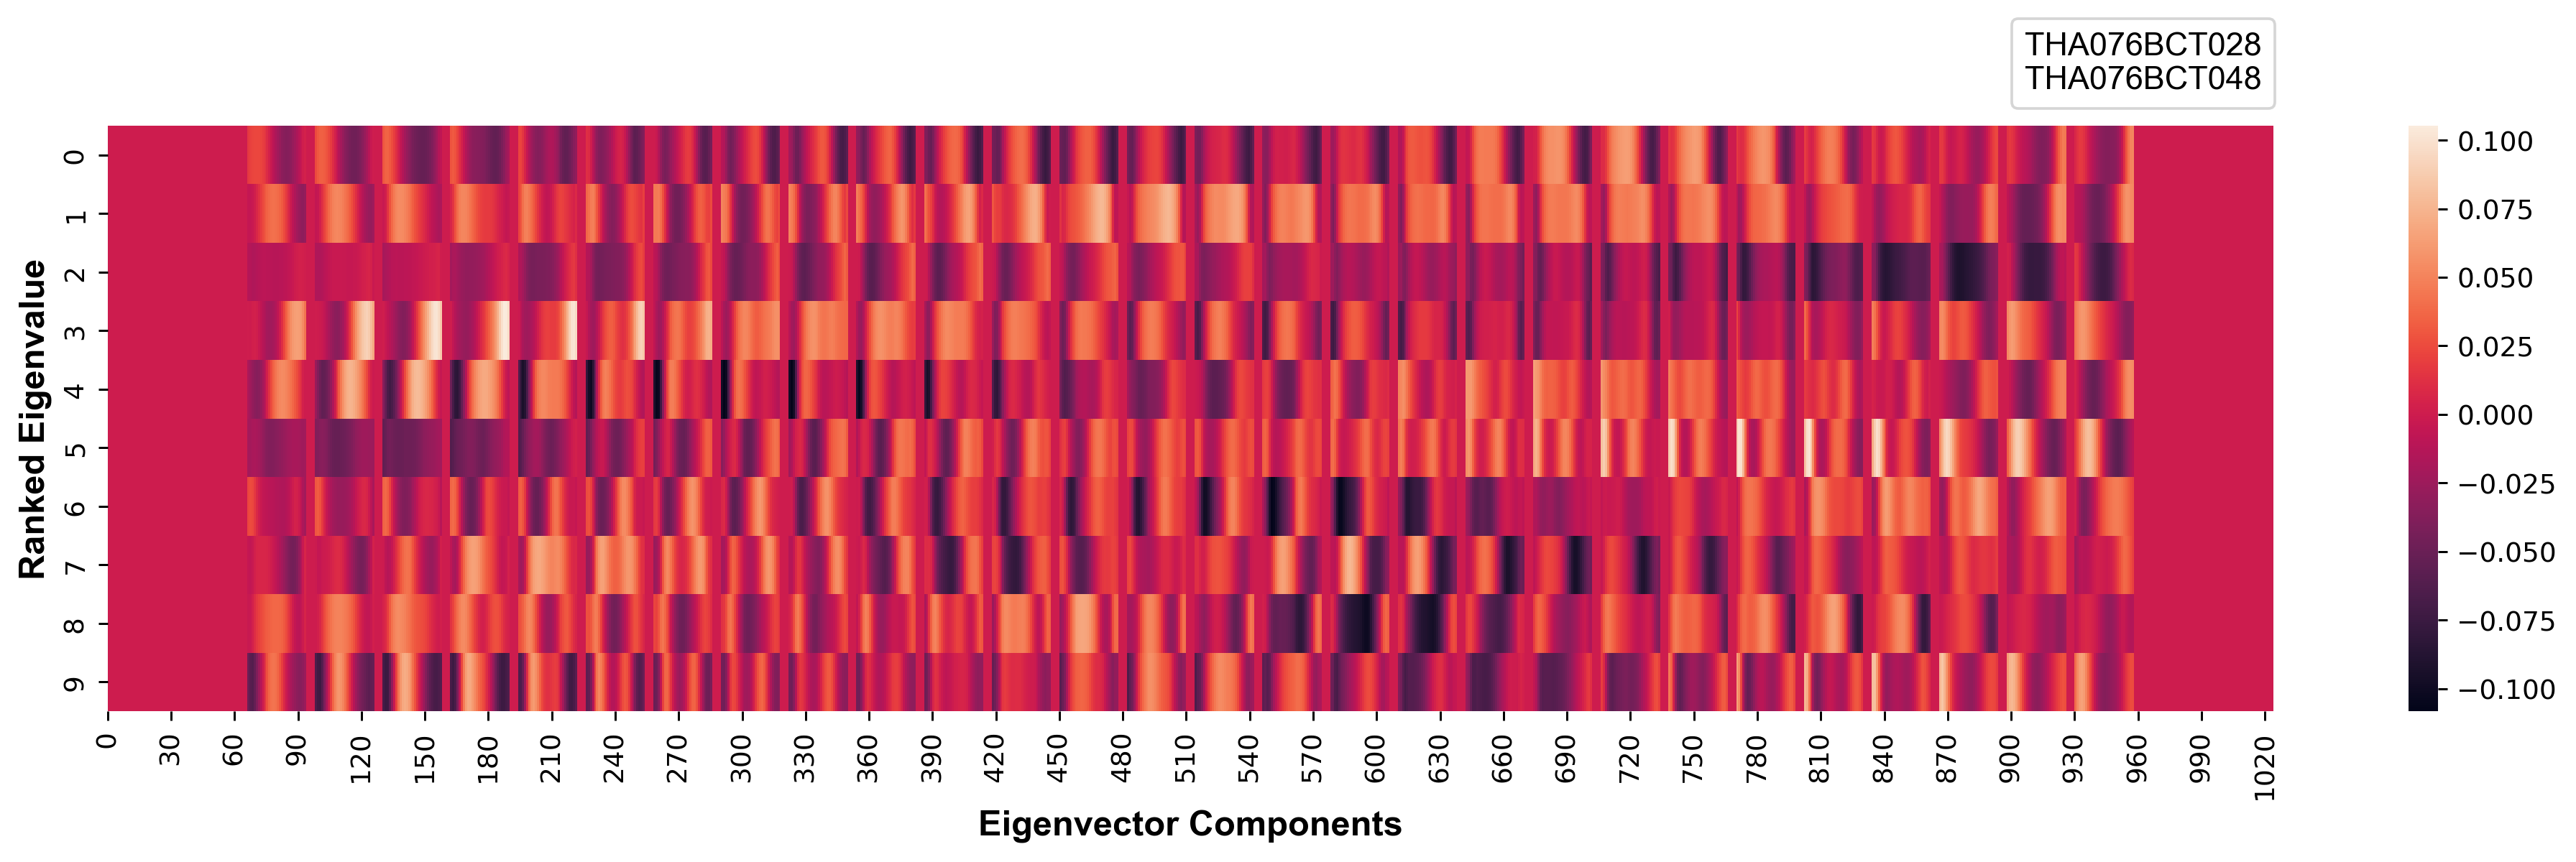

In [67]:
fig = plt.figure(figsize=(18,4), dpi = 270)
sns.heatmap(pd.DataFrame(eigenvectors[:10]), annot=False)
plt.ylabel("Ranked Eigenvalue", fontdict = {'size':13, 'weight':'bold', 'family':'Arial'})
plt.xlabel("Eigenvector Components", fontdict = {'size':13, 'weight':'bold', 'family':'Arial'})

legend_1 = plt.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font)
legend_1.set_bbox_to_anchor((1.008, 1.21))

sparse_ticks = range(0, 1024, 30)
sparse_tick_labels = range(0, 1024, 30)
plt.xticks(sparse_ticks, sparse_tick_labels)
plt.savefig('./Figures/Eigenvector Components vs Ranked Eigenvalue.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Analysis: (UJJWAL MAKE AMENDS)
1. This heatmap visualization of Eigenvector Components for Top 10 Ranked Eigenvalue basically identify which eigenvector components dominate in each eigenvalue. 
2. This is essentially a visualization of what information the principal component analysis has judged most important. 
3. The spots of high and low values indicate there may be a few values where the presence of a pixel is a strong indicator that a number is or is not a certain digit.

### Proportion of Variance
To measure the 'principalness' of each principal component, we can determine how much of the variance in the data it can explain.

In [68]:
lam_sum = sum(eigenvalues)
explained_variance = [(lam_k / lam_sum) for lam_k in sorted(eigenvalues, reverse = True)]

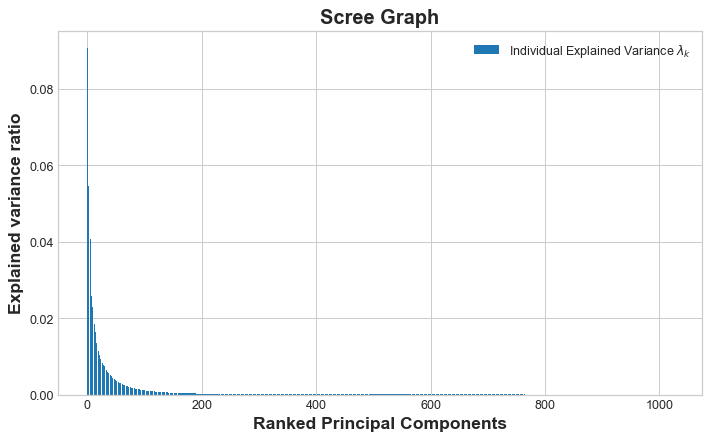

In [79]:
plt.figure(figsize=(8, 5), dpi = 90)
plt.style.use('seaborn-whitegrid')
font_title = {'size': 16, 'weight': 'bold', 'family':'Arial'}
font_label = {'size': 12, 'weight': 'bold', 'family':'Arial'}

plt.bar(range(len(explained_variance)), explained_variance,
        label='Individual Explained Variance $\lambda_{k}$', align = 'center', linewidth = .5)

plt.title("Scree Graph", fontdict = font_title)

plt.ylabel('Explained variance ratio', fontdict = font_label)
plt.xlabel('Ranked Principal Components', fontdict = font_label)

plt.legend(loc = 'best')
plt.tight_layout()
plt.show()


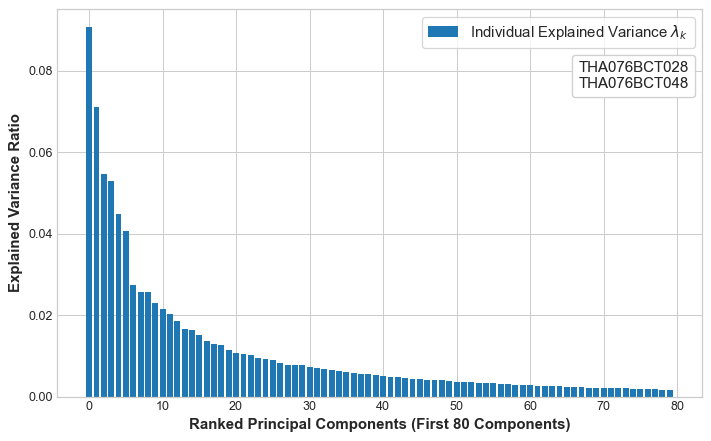

In [98]:
ax = plt.figure(figsize=(8, 5), dpi = 90)
plt.bar(range(len(explained_variance))[:80], explained_variance[:80],
        label='Individual Explained Variance $\lambda_{k}$', align = 'center', linewidth = .5)

plt.ylabel('Explained Variance Ratio', fontdict = {'size': 12, 'weight': 'bold', 'family':'Arial'})
plt.xlabel('Ranked Principal Components (First 80 Components)', fontdict = {'size': 12, 'weight': 'bold', 'family':'Arial'})

# Customize the legend
legend = plt.legend(markerscale=2, prop = font, frameon = True)
legend.set_bbox_to_anchor((1.0, 1.0))
 # Remove legend border

ax.add_artist(legend)
    
legend_1 = plt.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((1.0, 0.90))
ax.add_artist(legend_1)

plt.savefig('./Figures/Ranked Principal Components vs Explained Variance Ratio.png', dpi = 300, bbox_inches = 'tight')
plt.tight_layout()
plt.show()

The distribution of explained variance for each principal component provides an understanding of the amount of information that will be retained and lost when the original input, which has 784 dimensions, is reduced using the first N principal components.

In PCA, the eigenvalues represent the amount of variance explained by each principal component. <br>
- The scree plot allows you to assess the contribution of each principal component to the total variance in the data. 
- The scree plot typically has the eigenvalues on the y-axis and the number of principal components on the x-axis. 
- The eigenvalues are usually plotted as bars or points, with the eigenvalue magnitude decreasing as you move from left to right on the x-axis.
- The scree plot helps in identifying the point at which adding more principal components does not significantly contribute to the overall variance explained. 
- <b>The "elbow" point on the scree plot indicates the optimal number of principal components to retain. </b> (This point suggests a trade-off between retaining enough components to capture most of the variance and minimizing the dimensionality of the data.)<br><br>
By examining the scree plot, you can determine the number of principal components that explain a substantial portion of the variance in the data. This information guides the decision-making process when selecting the appropriate number of principal components for further analysis or dimensionality reduction.

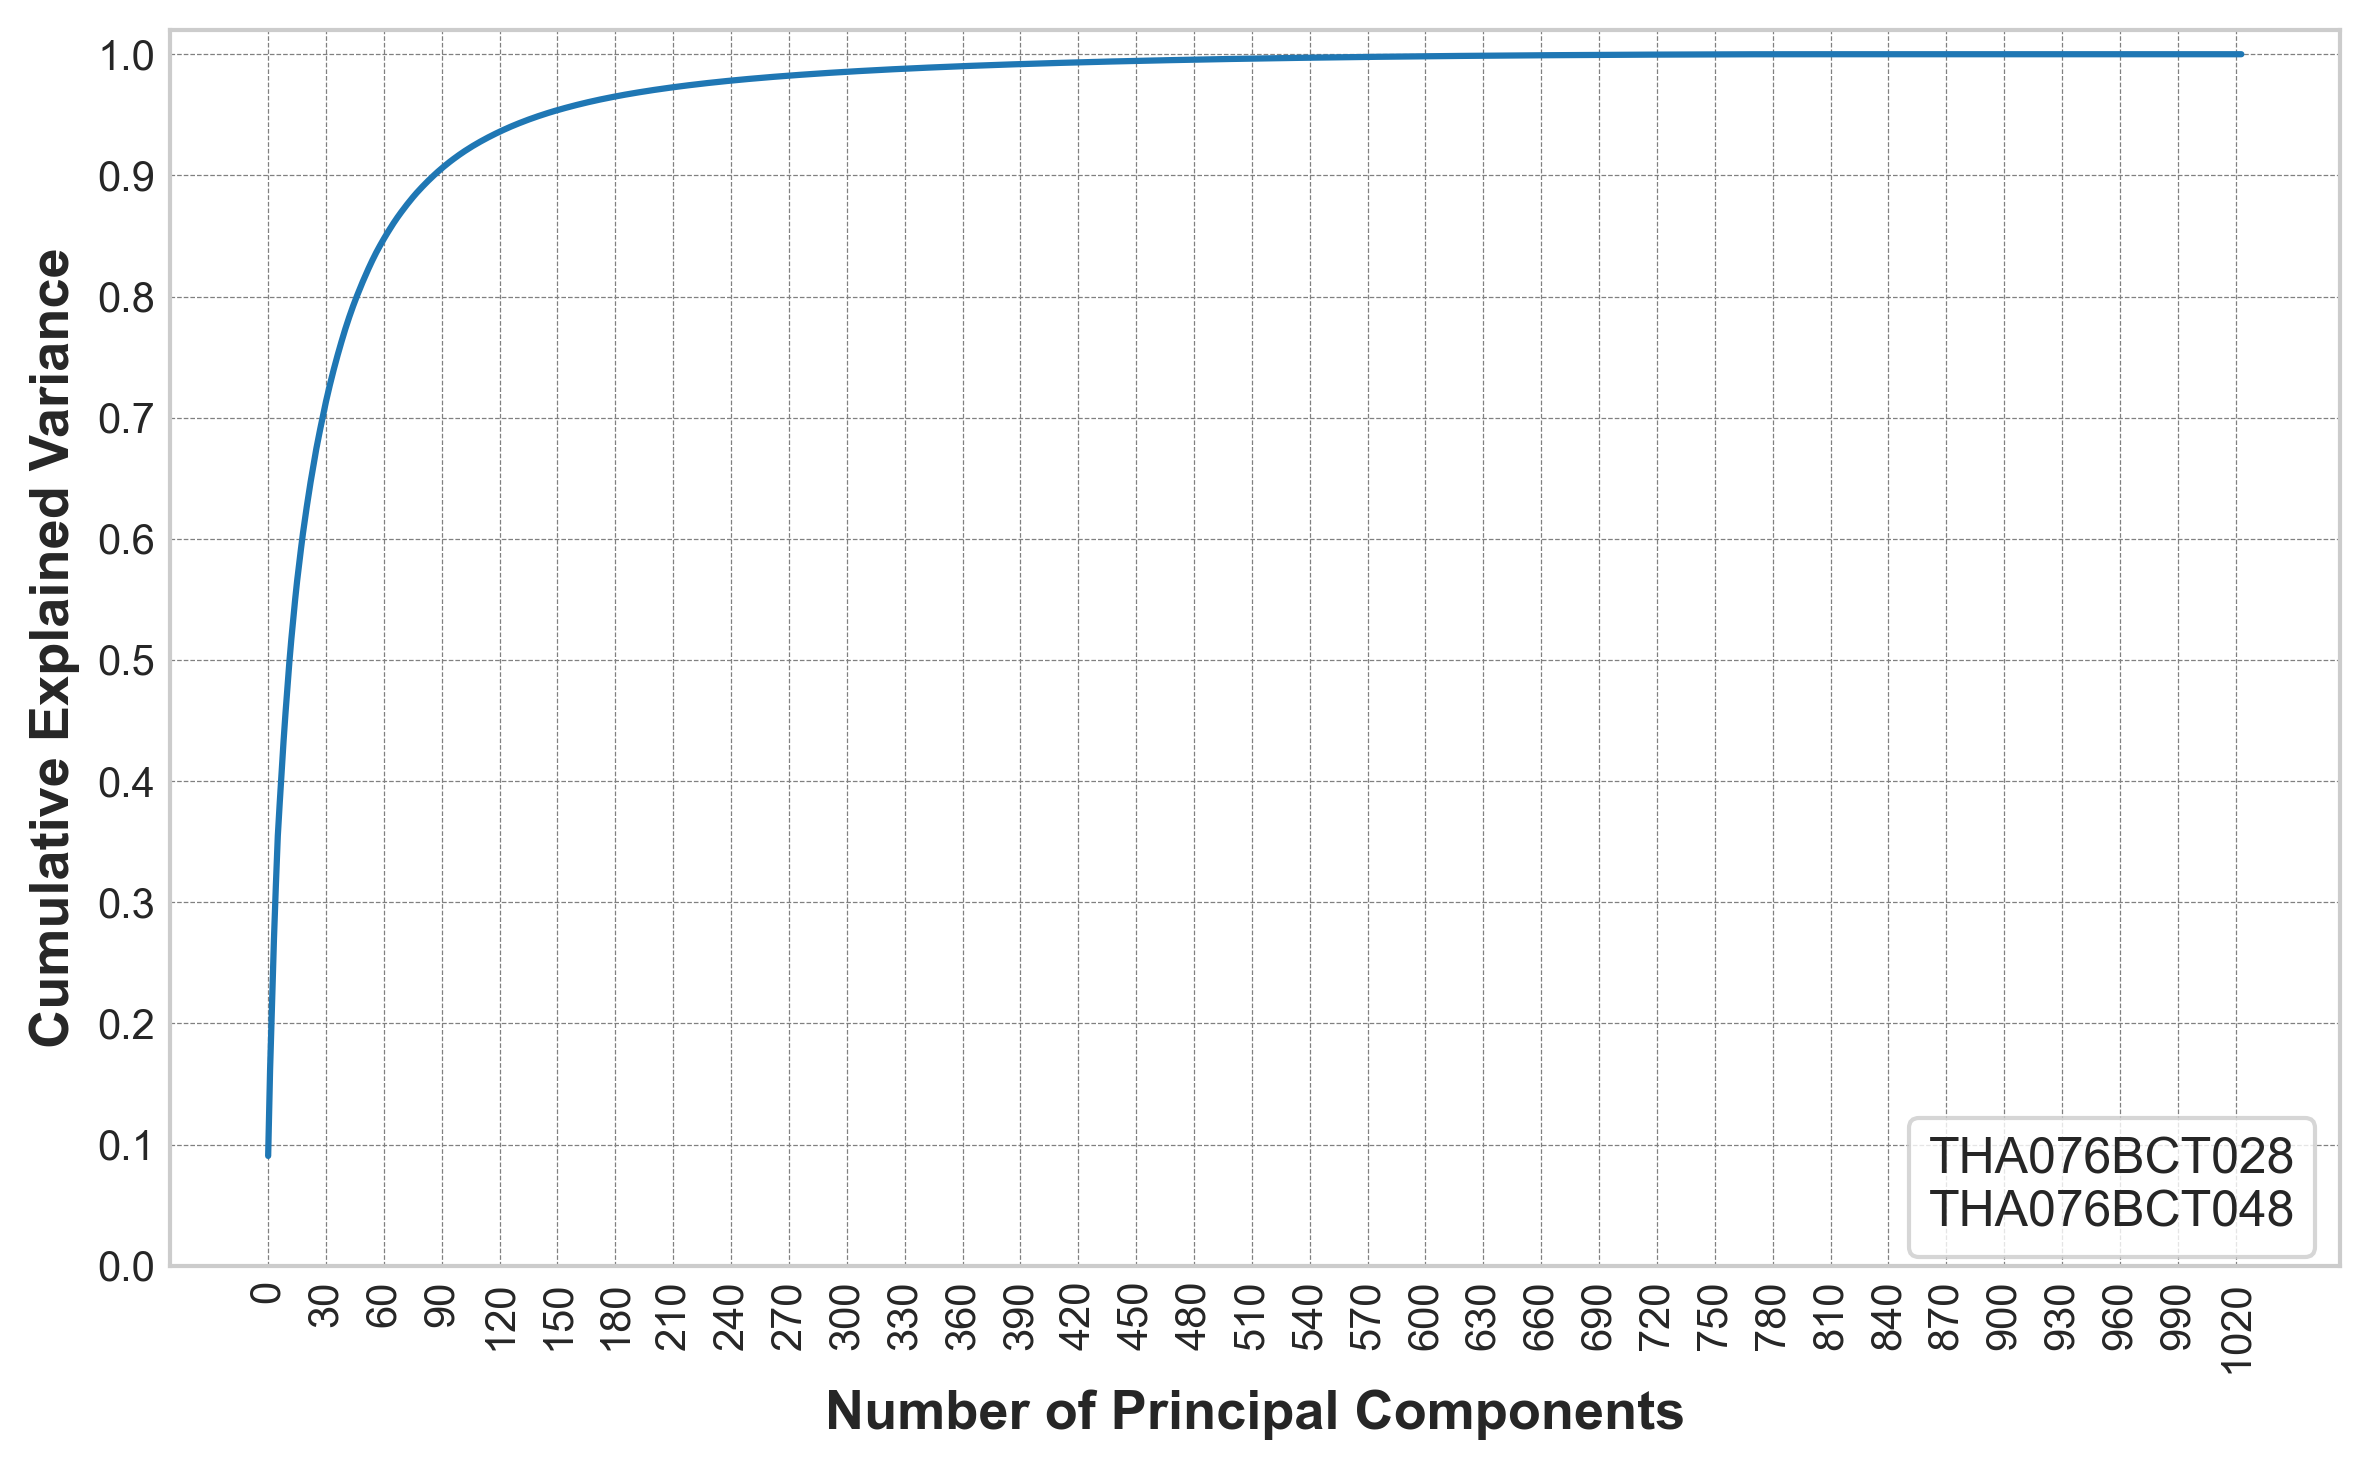

In [130]:
fig = plt.figure(figsize=(8, 5), dpi = 300)
plt.plot(np.cumsum(explained_variance))
plt.ylim([0,1.02])

plt.xlabel('Number of Principal Components', fontdict = {'size': 13, 'weight': 'bold', 'family':'Arial'})
plt.ylabel('Cumulative Explained Variance', fontdict = {'size': 13, 'weight': 'bold', 'family':'Arial'})
legend_1 = plt.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((1.0, 0.14))

sparse_ticks = range(0, 1024, 30)
sparse_tick_labels = range(0, 1024, 30)
plt.xticks(sparse_ticks, sparse_tick_labels, rotation = 'vertical')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.savefig('./Figures/No of principal components vs Cumulative Explained Variance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

This graph signifies how much of the total variance in the data is explained by each additional principal component. <br>
The x-axis represents the number of principal components included in the analysis, while the y-axis represents the cumulative proportion of variation explained by these components.<br> <b> As more principal components are included, the cumulative explained variance increases, indicating that the additional components capture more of the remaining variation in the data. The graph can be used to determine how many principal components are needed to explain a desired proportion of the total variation in the data. </b>

#### Transformation into New-Dimension Space (on New-Basis)

In [138]:
# PCA Components
n_components = 1024

transformed_Y = np.dot(eigenvectors[:n_components], scaled_X_train.T)
Y_cov = np.cov(transformed_Y) #be careful with this line, if scaled_Y.T is supplied than covariance for 60000 x 60000 will be calcualted and you machine will go under seizure

In [140]:
scaler_Y = StandardScaler()
new_scaled_Y = scaler_Y.fit_transform(transformed_Y.T)
Y_cov = np.cov(new_scaled_Y.T)

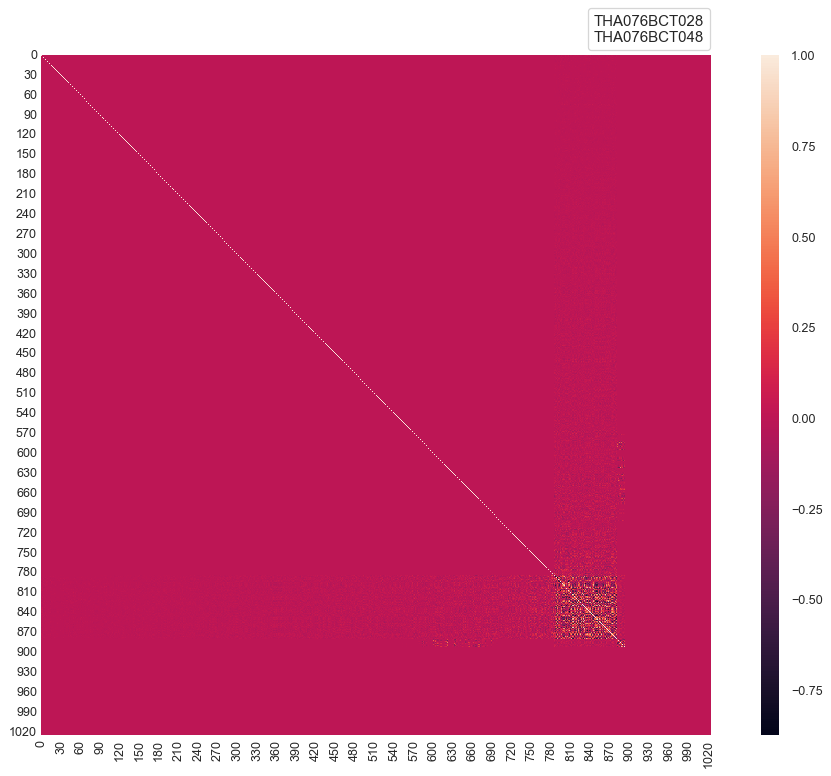

In [141]:
plt.figure(figsize=(12, 10), dpi = 90)
ax = sns.heatmap(Y_cov, annot=False)
plt.tick_params(axis='both', which='both', labelsize=10)
legend_1 = plt.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((1.010, 1.08))

# Increase the gap between the heatmap and the colorbar using the shrink parameter
cbar = ax.collections[0].colorbar
cbar.ax.set_aspect(20)  # Adjust the value as needed to increase the gap

sparse_ticks = range(0, len(X_cov), 30)
sparse_tick_labels = range(0, len(X_cov), 30)
plt.xticks(sparse_ticks, sparse_tick_labels)
plt.yticks(sparse_ticks, sparse_tick_labels)
plt.savefig('./Figures/Transformed Covariance Matrix.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Analysis:
1. A bright line exists along the principal diagonal but isn't visible due to the massive graph size. 
2. This truly demonstratest that the transformation of eigenvector basis has been able to reduce noise and can be applied to reduce the dimension of the data. i.e. High Variance along principal diagonal.
3. Also, lowest (nearly 0) value else where in the plot could signify that the covariance is nearly zero which means that the correlation between attribtues is low as possible and thus the redundancy is removed.
4. In a typical scenario, the covariance matrix of the transformed Y in PCA analysis should have the highest value along the principal diagonal. The principal components are constructed in a way that the first component captures the maximum variance in the data, the second component captures the next highest variance orthogonal to the first component, and so on. But, in this case, the heatmap of the covariance matrix of the transformed Y doesn't exhibit maximum value along the principal diagonal from (765, 765), this is actually due to clipping effect in the eigenvalues. <br>
NOTE: The covariance matrix can be influenced by factors such as data scaling and preprocessing

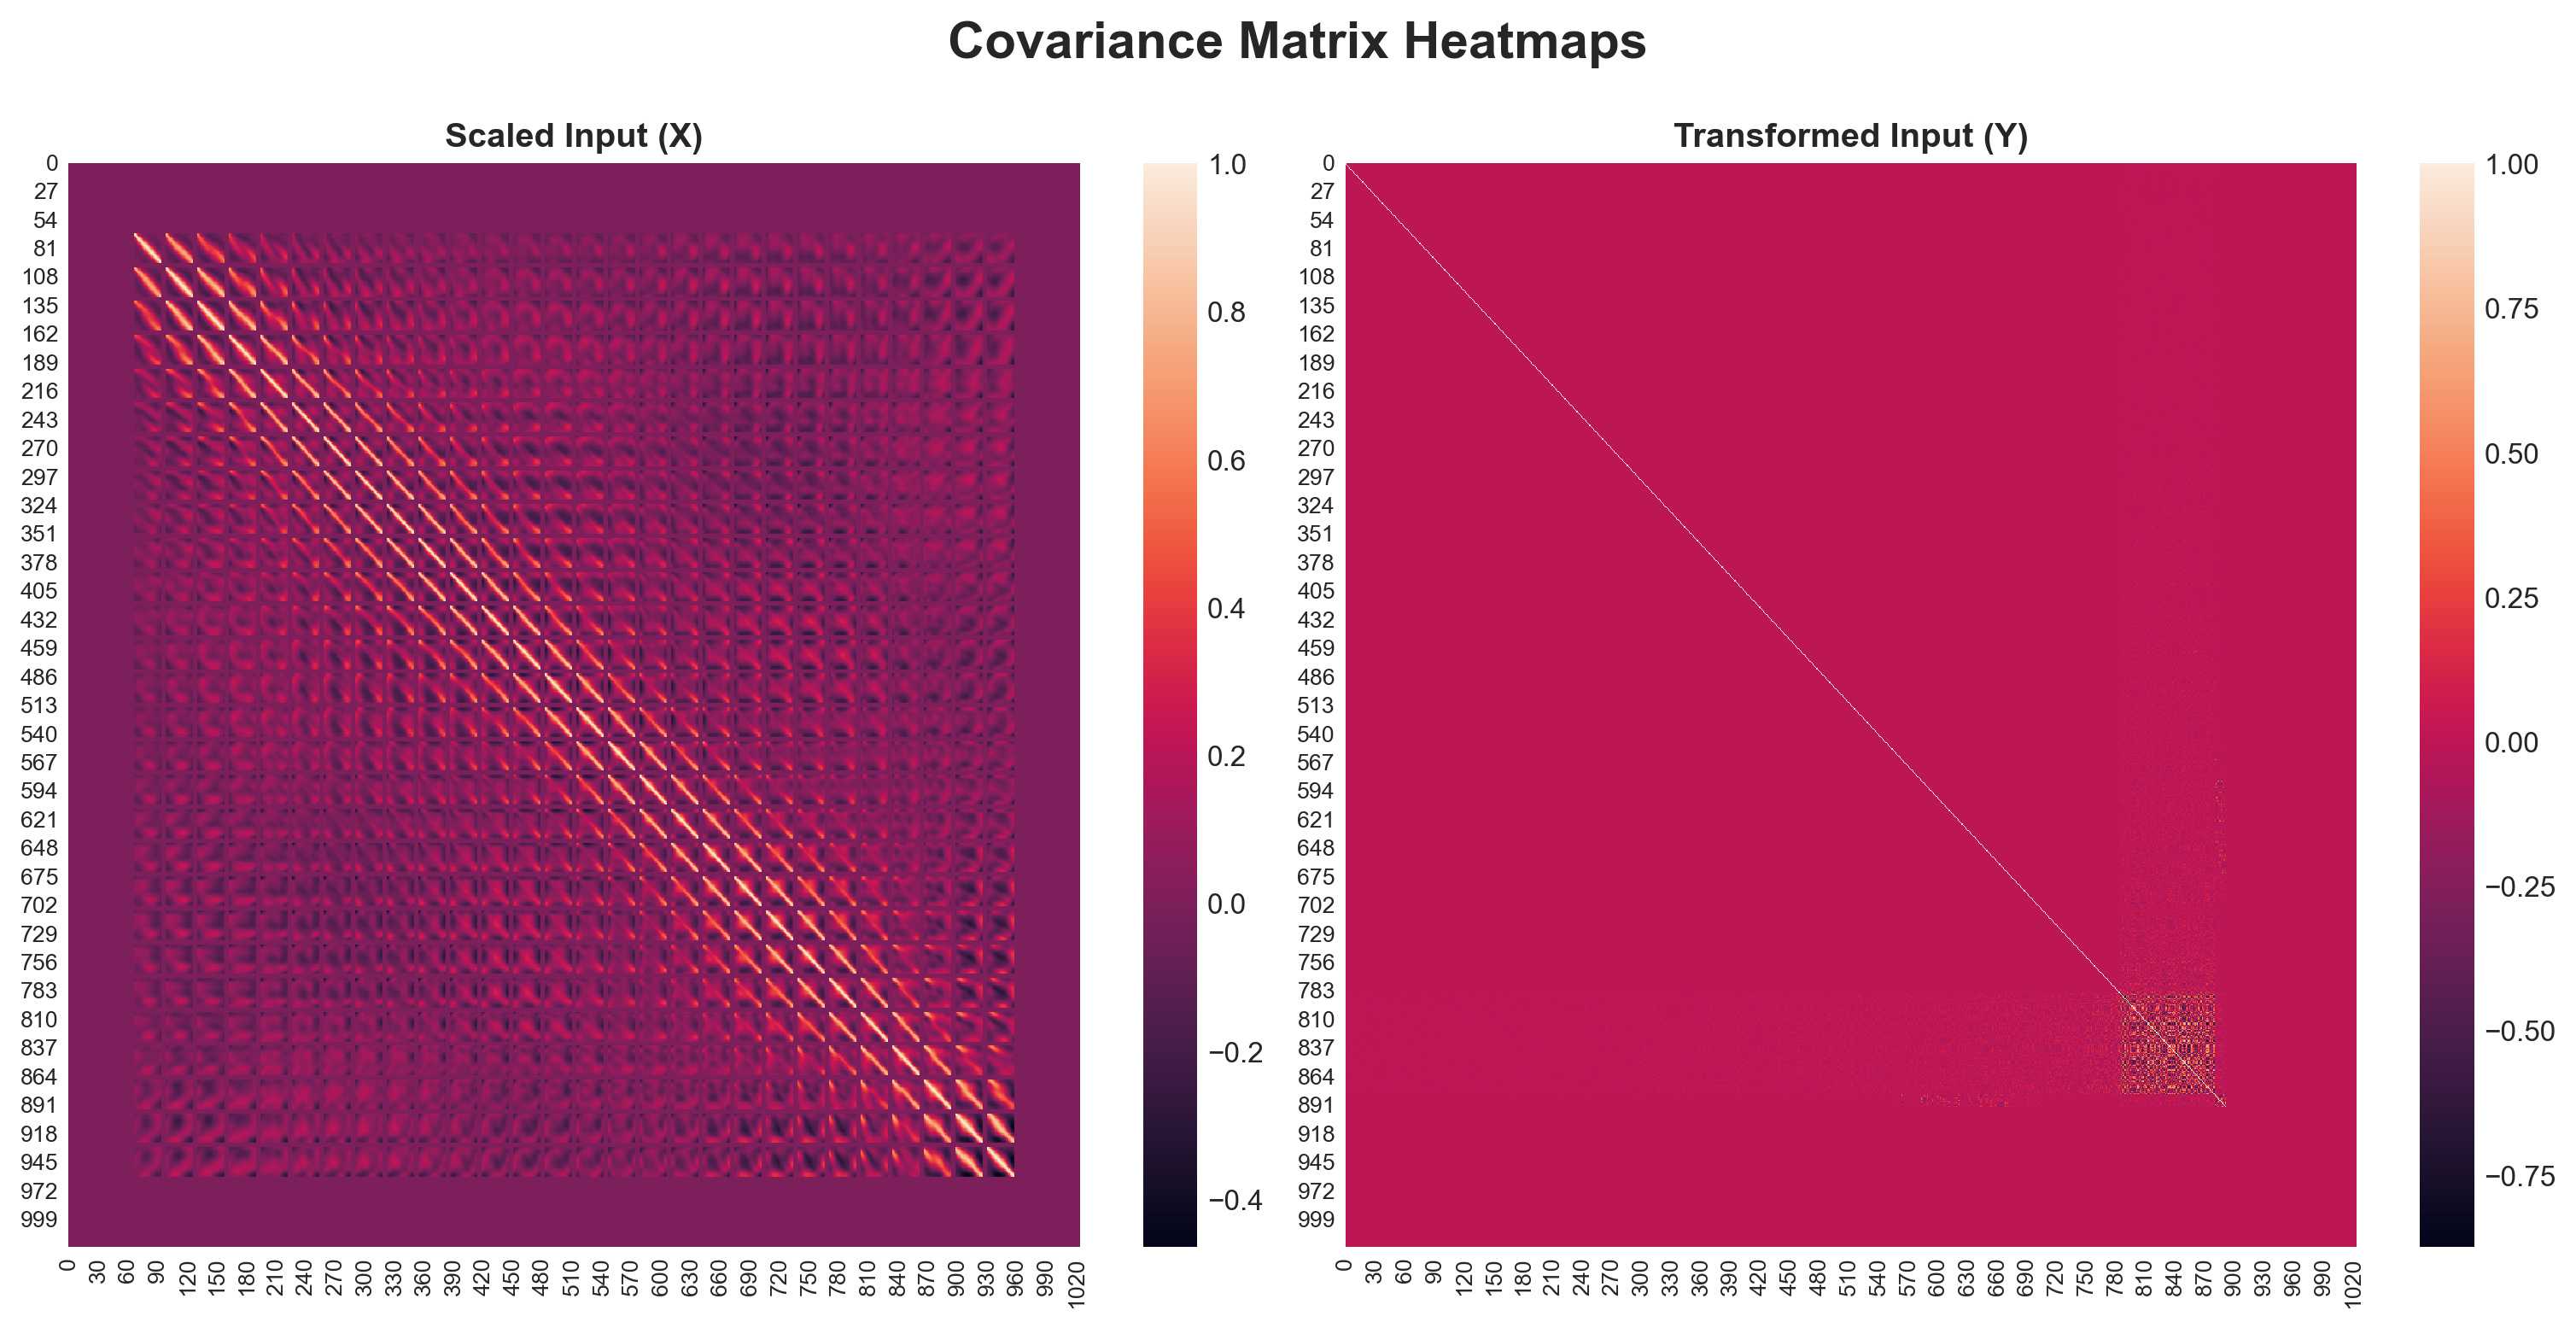

In [145]:
fig, axes = plt.subplots(1, 2, figsize = (16, 7), dpi =240)
fig.suptitle('Covariance Matrix Heatmaps', fontsize = 18, fontweight = 'bold')
fig.subplots_adjust(wspace = 0.01)

sns.heatmap(X_cov, annot = False, ax = axes[0])
axes[0].set_title('Scaled Input (X)', fontdict = {'size':12, 'weight':'bold'})
axes[0].tick_params(axis = 'both', labelsize = 8)

sns.heatmap(Y_cov, annot = False, ax = axes[1])
axes[1].set_title('Transformed Input (Y)', fontdict = {'size':12, 'weight':'bold'})
axes[1].tick_params(axis = 'both', labelsize = 8)
plt.show()

#### Analysis
1. This comparison of covariance matrix heatmaps between the Scaled Input (X) and the Transformed Input (Y) clearly shows that after PCA, the variance of the elements is increased, indicating that more important information is now visible. Additionally, the correlation between dimensions, i.e., the covariance, is minimized as much as possible.

In [146]:
def PCA_m(n_com):
    transformed_Y = np.dot(eigenvectors[:n_com], scaled_X_train.T)
    return transformed_Y.T

In [147]:
def get_n_principal_components(n):
    return eigenvectors[:n]

#### Visualizing the Principle Components

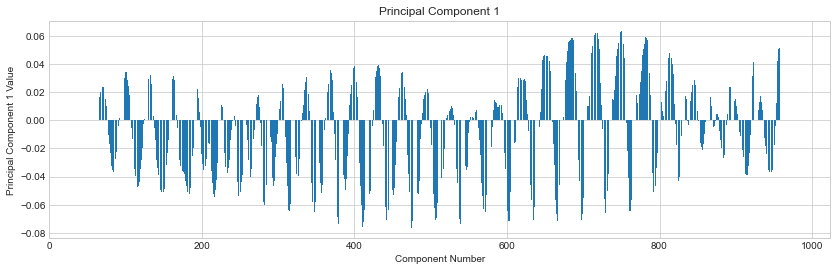

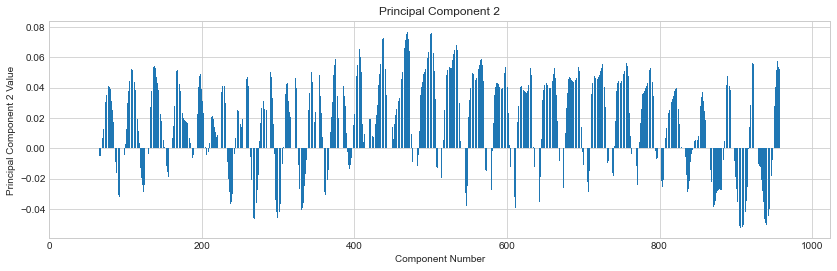

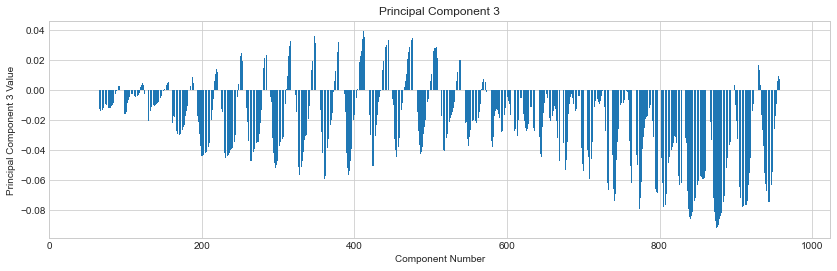

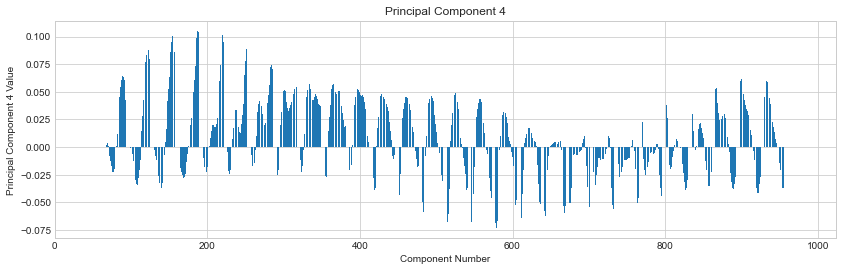

In [148]:
first_four_components = get_n_principal_components(4)
for i in range(4):
    fig = plt.figure(figsize = (14, 4))
    plt.bar(range(len(first_four_components[i])), first_four_components[i])
    plt.xlabel('Component Number')
    plt.ylabel('Principal Component '+str(i+1)+' Value')
    plt.title('Principal Component '+str(i+1))
    plt.xlim(0, 1024)
    plt.show()

#### Analysis:
1. This barplot of first four prominent principal components shows what eigenvector components is important.
2. If this 784 dimension principal components is reshaped to (28, 28) image, then a pattern can be seen whose description would be that the pixels where there is absence of intensity, the corresponding principal component value is 0 and for the presence of any digit pixel, the corresponding value is high.
3. Likewise, each principal components shows on which part of the pixel (28 x 28 => 784), does that principal component give emphasis to.

#### Lets compare the Principal Components with Sklearn PCA

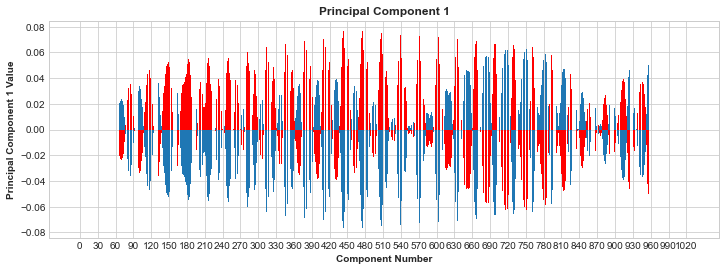

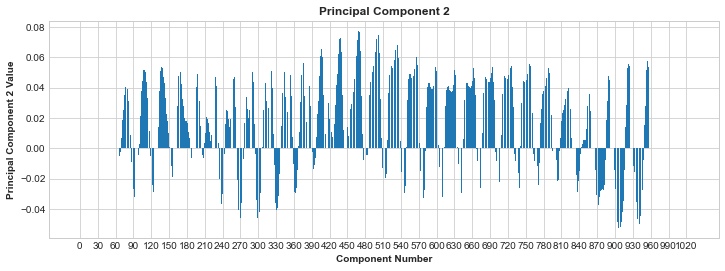

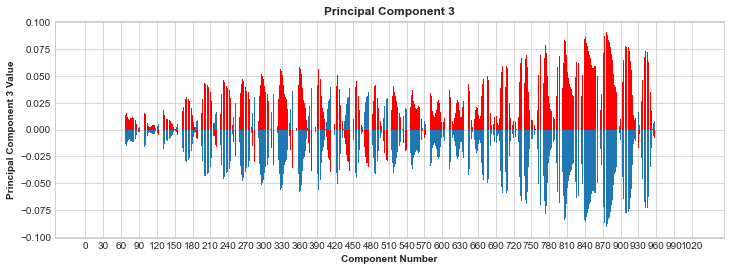

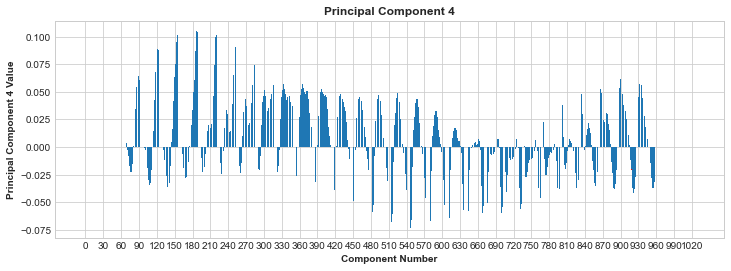

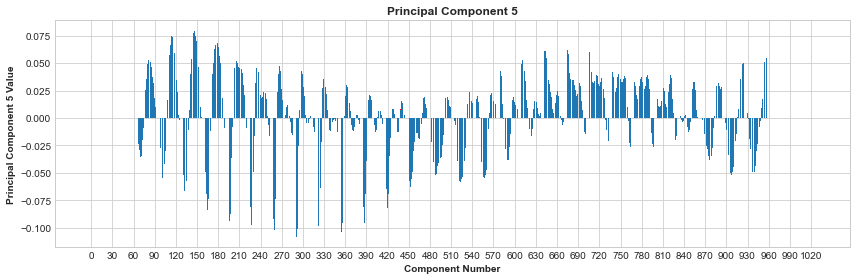

In [192]:
sklearn_pca = PCA(n_components = 5).fit(scaled_X_train)
first_five_components = get_n_principal_components(5)

for i in range(5):
    fig = plt.figure(figsize = (12, 4))   
    plt.bar(range(len(sklearn_pca.components_[i])), sklearn_pca.components_[i], color = 'red')
    plt.bar(range(len(first_five_components[i])), first_five_components[i])
    
    plt.xlabel('Component Number', fontdict = {'family':'Arial', 'size':10, 'weight':'bold'})
    plt.ylabel('Principal Component '+str(i+1)+' Value', fontdict = {'family':'Arial', 'size':10, 'weight':'bold'})
    plt.title('Principal Component '+str(i+1), fontdict = {'family':'Arial', 'size':12, 'weight':'bold'})
    
    sparse_ticks = range(0, 1024, 30)
    sparse_tick_labels = range(0, 1024, 30)
    plt.xticks(sparse_ticks, sparse_tick_labels)

plt.tight_layout()
plt.show()

In [185]:
sklearn_pca = PCA(n_components = 5).fit(scaled_X_train)
first_five_components = get_n_principal_components(5)

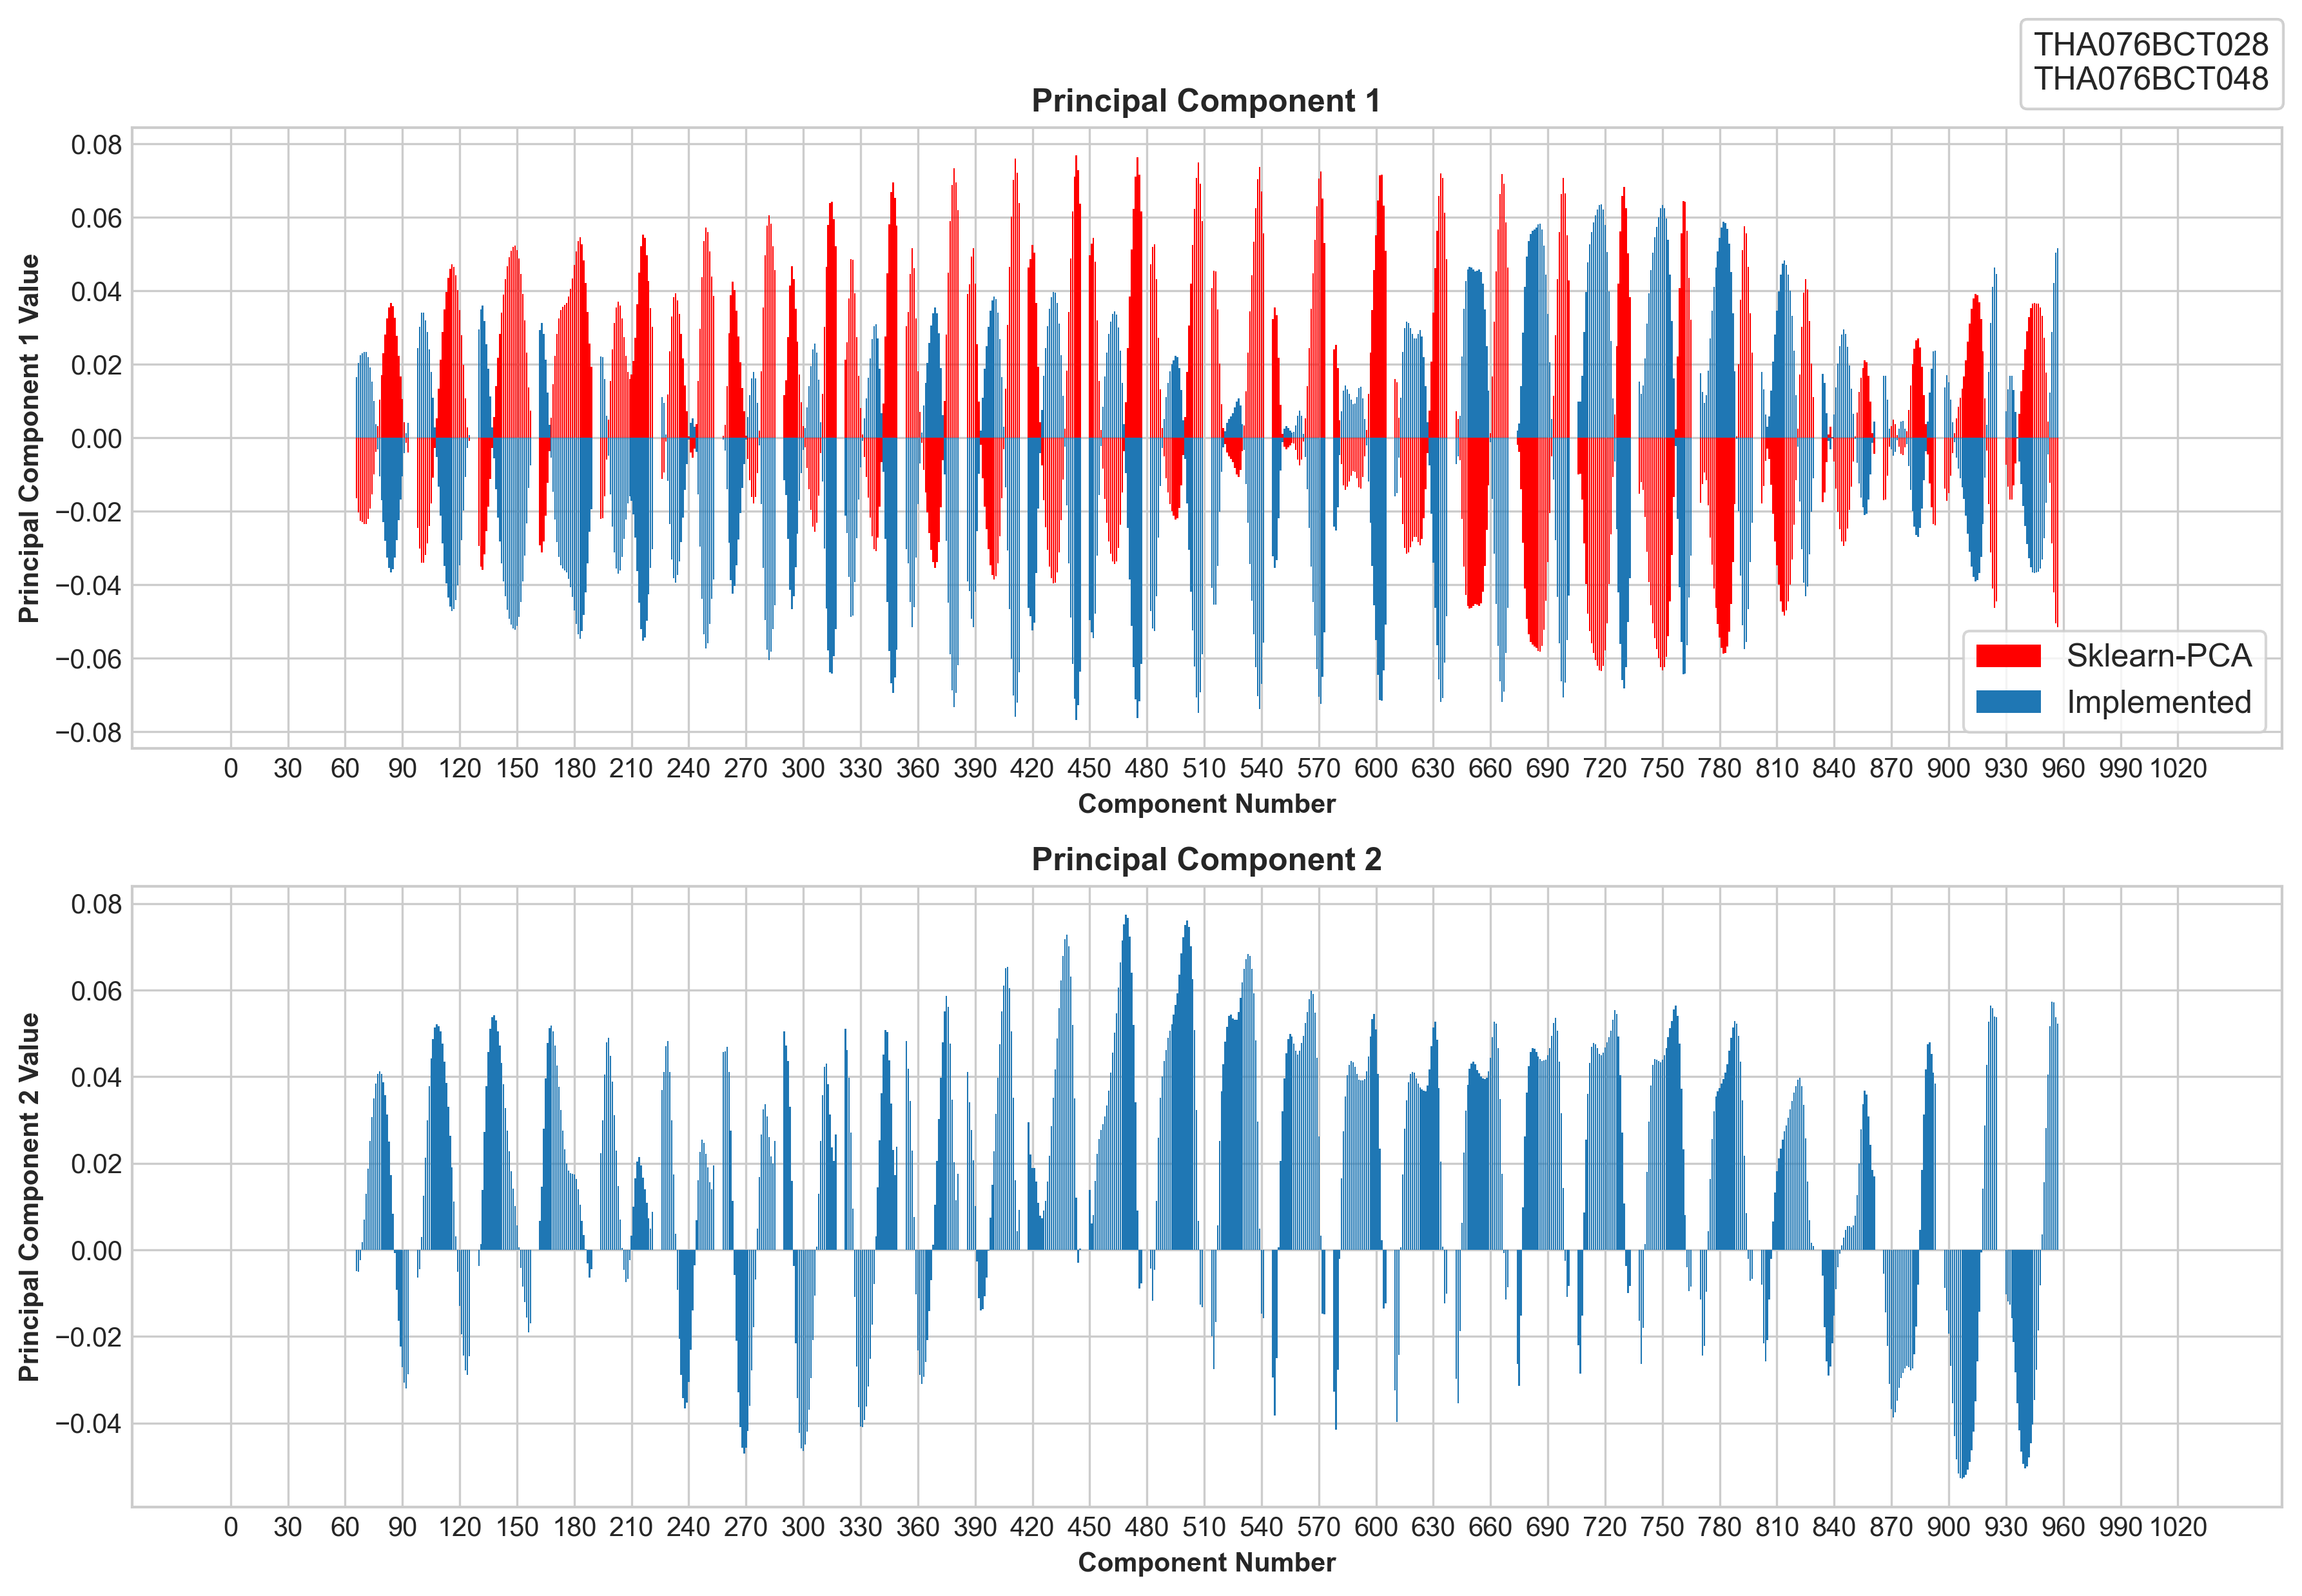

In [202]:
fig = plt.figure(figsize=(12, 8), dpi=300)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

bar1 = ax1.bar(range(len(sklearn_pca.components_[0])), sklearn_pca.components_[0], color='red', label='Sklearn-PCA')
bar2 = ax1.bar(range(len(first_five_components[0])), first_five_components[0], label='Implemented')
ax1.set_xlabel('Component Number', fontdict={'family': 'Arial', 'size': 10, 'weight': 'bold'})
ax1.set_ylabel('Principal Component 1 Value', fontdict={'family': 'Arial', 'size': 10, 'weight': 'bold'})
ax1.set_title('Principal Component 1', fontdict={'family': 'Arial', 'size': 12, 'weight': 'bold'})
ax1.set_xticks(range(0, 1024, 30))

legend = ax1.legend(handles=[bar1, bar2], prop=font, frameon=True, loc='lower right')

# Add name_legend to ax1
name_legend = ax1.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop=font, frameon=True)
name_legend.set_bbox_to_anchor((1.008, 1.20))
ax1.add_artist(legend)
ax1.add_artist(name_legend)


# Plot for Principal Component 2
ax2.bar(range(len(sklearn_pca.components_[1])), sklearn_pca.components_[1], color='red')
ax2.bar(range(len(first_five_components[1])), first_five_components[1])
ax2.set_xlabel('Component Number', fontdict={'family': 'Arial', 'size': 10, 'weight': 'bold'})
ax2.set_ylabel('Principal Component 2 Value', fontdict={'family': 'Arial', 'size': 10, 'weight': 'bold'})
ax2.set_title('Principal Component 2', fontdict={'family': 'Arial', 'size': 12, 'weight': 'bold'})
ax2.set_xticks(range(0, 1024, 30))

plt.tight_layout()

plt.savefig('./Figures/Sklearn-PCAvsImplemented_PCs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Analysis:
1. This is an overlap of barplot of the corresponding top 5 principal components from our generated and the one generated by the PCA module from skleran.
2. The 'red' element is from the PCA module and the 'blue' element is our implemented PCA model.
3. For PC1, PC2 and PC5, we can see that there is near to perfect overlap between the corresponding PC values for that particular components.
4. But, for PC3 and PC4, we can see that the bar plot of both are inverted to each other. This might be due to the fact that each principal component is perpendicular to the previous component, and since there is 2 possible perpendiculars to a given plane (to say) so what could have happened is that on PC3 and PC4 the perpendiculars are just opposite resulting is opposite direction but equal magnitudes. 

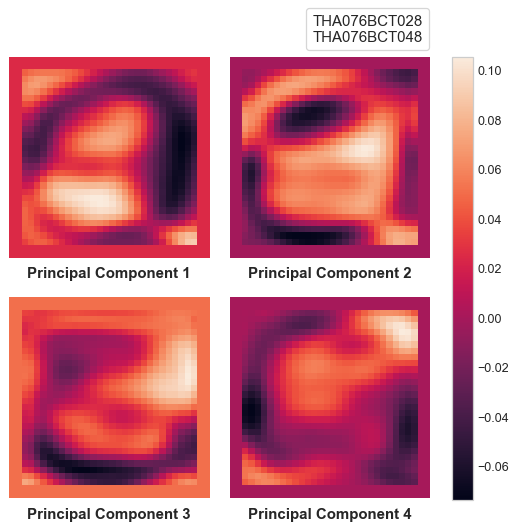

In [277]:
fig = plt.figure(figsize=(12, 6), dpi = 90)
plt.subplots_adjust(left=0.01, right=0.40, bottom=0.05, top=0.90, wspace=0.1, hspace=0.1)
axes = [fig.add_subplot(220 + i + 1) for i in range(4)]

first_six_components = get_n_principal_components(4)

for i, ax in enumerate(axes):
    sns.heatmap(first_six_components[i].reshape(32, 32), 
                square=True, ax=ax, cbar = False)
    ax.axis('off')
    
    title = 'Principal Component ' + str(i + 1)
    ax.text(0.5, -0.1, title, fontsize = 12, weight = 'bold', ha = 'center', transform = ax.transAxes, family = 'Arial')

cax = fig.add_axes([0.42, 0.063, 0.02, 0.82])  # Position of the colorbar
cax.grid(False)
plt.colorbar(ax.collections[0], cax=cax)  # ax.collections[0] refers to the heatmap collection

name_legend = axes[0].legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop=font, frameon=True)
name_legend.set_bbox_to_anchor((2.13, 1.28))

plt.savefig('./Figures/Principal Component Visualization.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Analysis:
1. Here is the heatmap plot of first six principal components. 
2. This plot is a better visualization in compared to the bar plot shown above.
3. This validates our above analysis that the pixels with bright intensity is the region where that particular principal component is giving more emphasis and the pixels to dark intensity. 
4. Also different principal components gives emphasis to differnt sturcture of the input digit data. 

#### Explained variance

In [278]:
explained_variance_df = pd.DataFrame(([(j, np.cumsum(explained_variance)[j]) for j in range(len(explained_variance))]), columns = ['Principal Components', 'Variance Retained'])
explained_variance_df.head(2)

Principal Components  Variance Retained
0                     0           0.090655
1                     1           0.161857

This shows how much of the variance will be explained if we select first N principal components.
- 5 PC will explain 35% of the variance.
- 20 PC will explain 62% of the variance.
- 42 PC will explain 80% of the variance.
- 86 PC will explain 90% of the variance.
- 143 PC will explain 95% of the variance.

### Projection into Feature Subspace

In [304]:
# Lets work with 5-PC components for now:
Y = PCA_m(100)

In [280]:
Y

array([[ -6.64614836, -10.67026022,   1.48185637,  -3.76188319,
          1.43215462],
       [ -8.19199014, -11.97287189,   2.12421387,  -2.64781348,
          2.60179321],
       [-10.28695941,  -6.47796629,  -3.04135987,  -9.71275415,
          1.40330787],
       ...,
       [ -2.37755503,  -7.9577596 ,  -1.0075722 ,  11.89927582,
          3.32984819],
       [ -6.35422048,  -1.90056261,   3.67877096,   7.70241451,
         -3.11646379],
       [-11.01389633,   2.26056397,  -7.94844556,  14.9792191 ,
          2.06841878]])

In [281]:
# To color each point by the digit it represents,
# create a color map with 10 elements (10 RGB values).
# Then, use the system response (y_training), which conveniently
# is a digit from 0 to 9.
def get_cmap(n):
    #colorz = plt.cm.cool
    colorz = plt.get_cmap('tab10')
    return [ colorz(float(i)/n * 1.1) for i in range(n)]

colorz = get_cmap(10)
colors = [colorz[int(yy.split("_")[-1])] for yy in (y_train_target)]

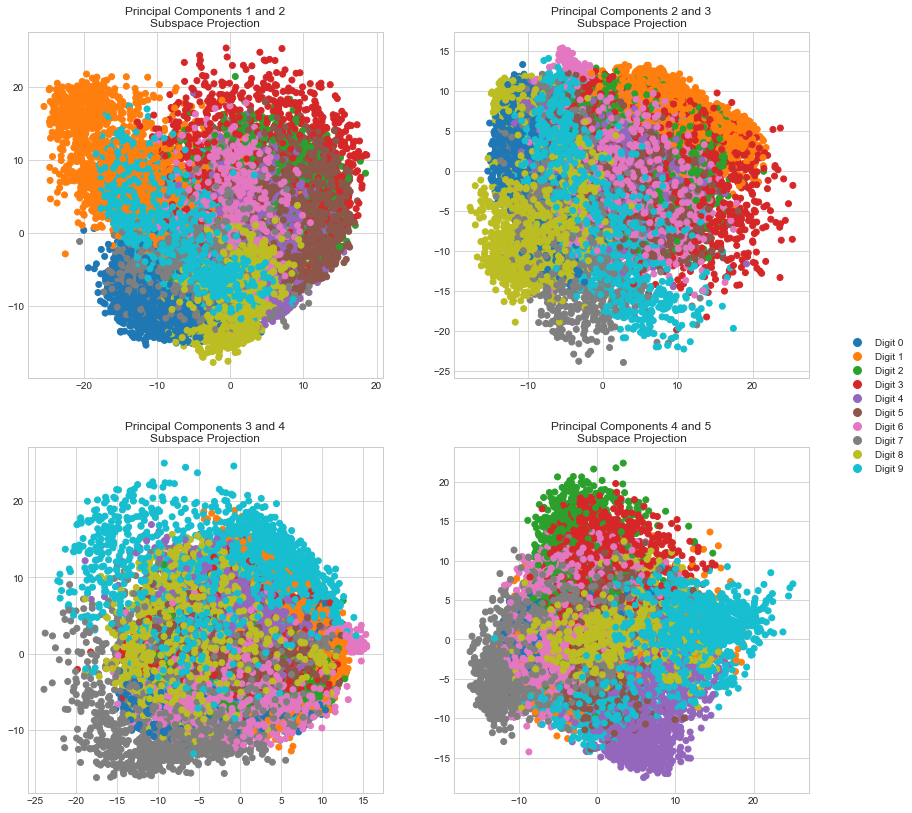

Explained Variance, Principal Component 1: 28.87%
Explained Variance, Principal Component 2: 22.68%
Explained Variance, Principal Component 3: 17.38%
Explained Variance, Principal Component 4: 16.83%
Explained Variance, Principal Component 5: 14.25%


In [282]:
fig = plt.figure(figsize=(14,14))
axes = [fig.add_subplot(220 + i + 1) for i in range(4)]

axes[0].scatter( Y[:,0], Y[:,1] , c = colors)
axes[0].set_title('Principal Components 1 and 2\nSubspace Projection')

axes[1].scatter( Y[:,1], Y[:,2] , c = colors )
axes[1].set_title('Principal Components 2 and 3\nSubspace Projection')

axes[2].scatter( Y[:,2], Y[:,3] , c = colors )
axes[2].set_title('Principal Components 3 and 4\nSubspace Projection')

axes[3].scatter( Y[:,3], Y[:,4] , c = colors )
axes[3].set_title('Principal Components 4 and 5\nSubspace Projection')

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i),
                              markerfacecolor=colorz[i], markersize=10) for i in range(10)]
legend = fig.legend(handles = legend_elements, loc='center right')
fig.canvas.draw()

plt.show()

n_components = 5
total_variance = np.sum(explained_variance[0:n_components])
for i in range(n_components):
    print("Explained Variance, Principal Component %d: %0.2f%%"%(i + 1, explained_variance[i] * 100/total_variance))

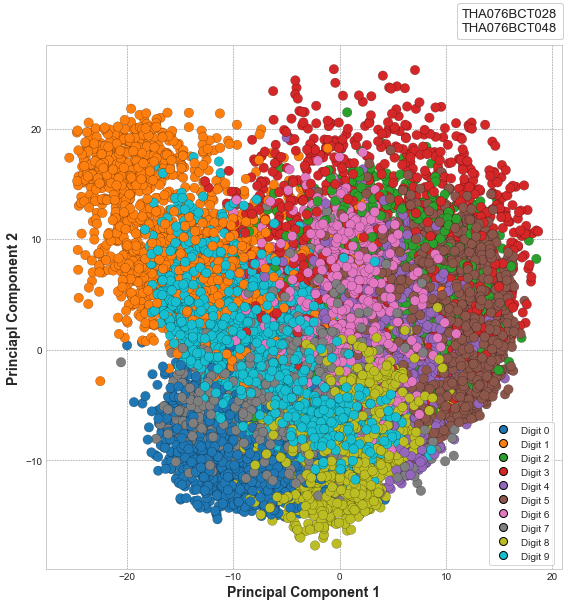

In [409]:
fig = plt.figure(figsize=(8, 8))

plt.scatter( Y[:, 0], Y[:, 1] , c = colors, linewidths = 0.18, edgecolors=['black'] * len(Y), s = 90)
# plt.title('Principal Components 1 and 2\nSubspace Projection')

plt.xlabel
# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i),
                              markerfacecolor=colorz[i], markersize = 8, linewidth = 0.15, markeredgecolor = 'black') for i in range(10)]
legend_1 = fig.legend(handles = legend_elements, frameon = True, fancybox = True)
legend_1.set_bbox_to_anchor((0.97, 0.33))

font = FontProperties(family='Arial', size = 13)
name_legend = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop = font, frameon=True)
name_legend.set_bbox_to_anchor((0.988, 1.06))
fig.add_artist(name_legend)

# fig.canvas.draw()


plt.xlabel('Principal Component 1', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
plt.ylabel('Princiapl Component 2', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})

plt.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('./Figures/PC1 VS PC2 - BEST 2d Plot Example.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Worst 2D Principal Component Example

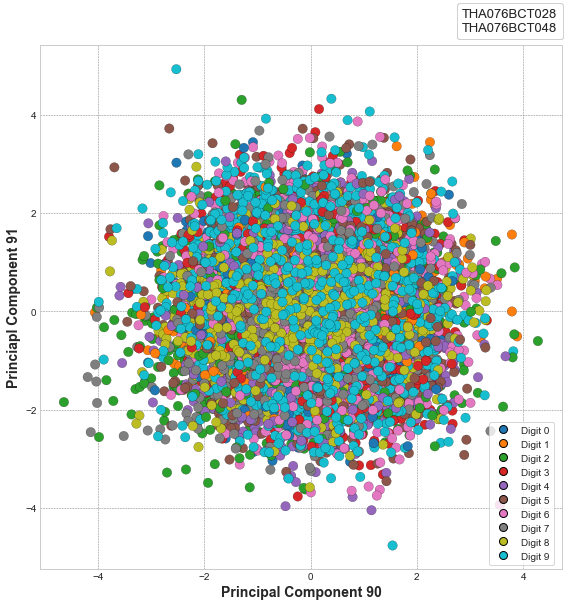

In [411]:
fig = plt.figure(figsize=(8, 8))

plt.scatter( Y[:, 90], Y[:, 91] , c = colors, linewidths = 0.18, edgecolors=['black'] * len(Y), s = 90)
# plt.title('Principal Components 1 and 2\nSubspace Projection')

plt.xlabel
# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i),
                              markerfacecolor=colorz[i], markersize = 8, linewidth = 0.15, markeredgecolor = 'black') for i in range(10)]
legend_1 = fig.legend(handles = legend_elements, frameon = True, fancybox = True)
legend_1.set_bbox_to_anchor((0.97, 0.33))

font = FontProperties(family='Arial', size = 13)
name_legend = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop = font, frameon=True)
name_legend.set_bbox_to_anchor((0.988, 1.06))
fig.add_artist(name_legend)

# fig.canvas.draw()


plt.xlabel('Principal Component 90', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
plt.ylabel('Princiapl Component 91', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})

plt.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('./Figures/PC90 VS PC91 - Worst 2d Plot Example.png', dpi = 300, bbox_inches = 'tight')
plt.show()

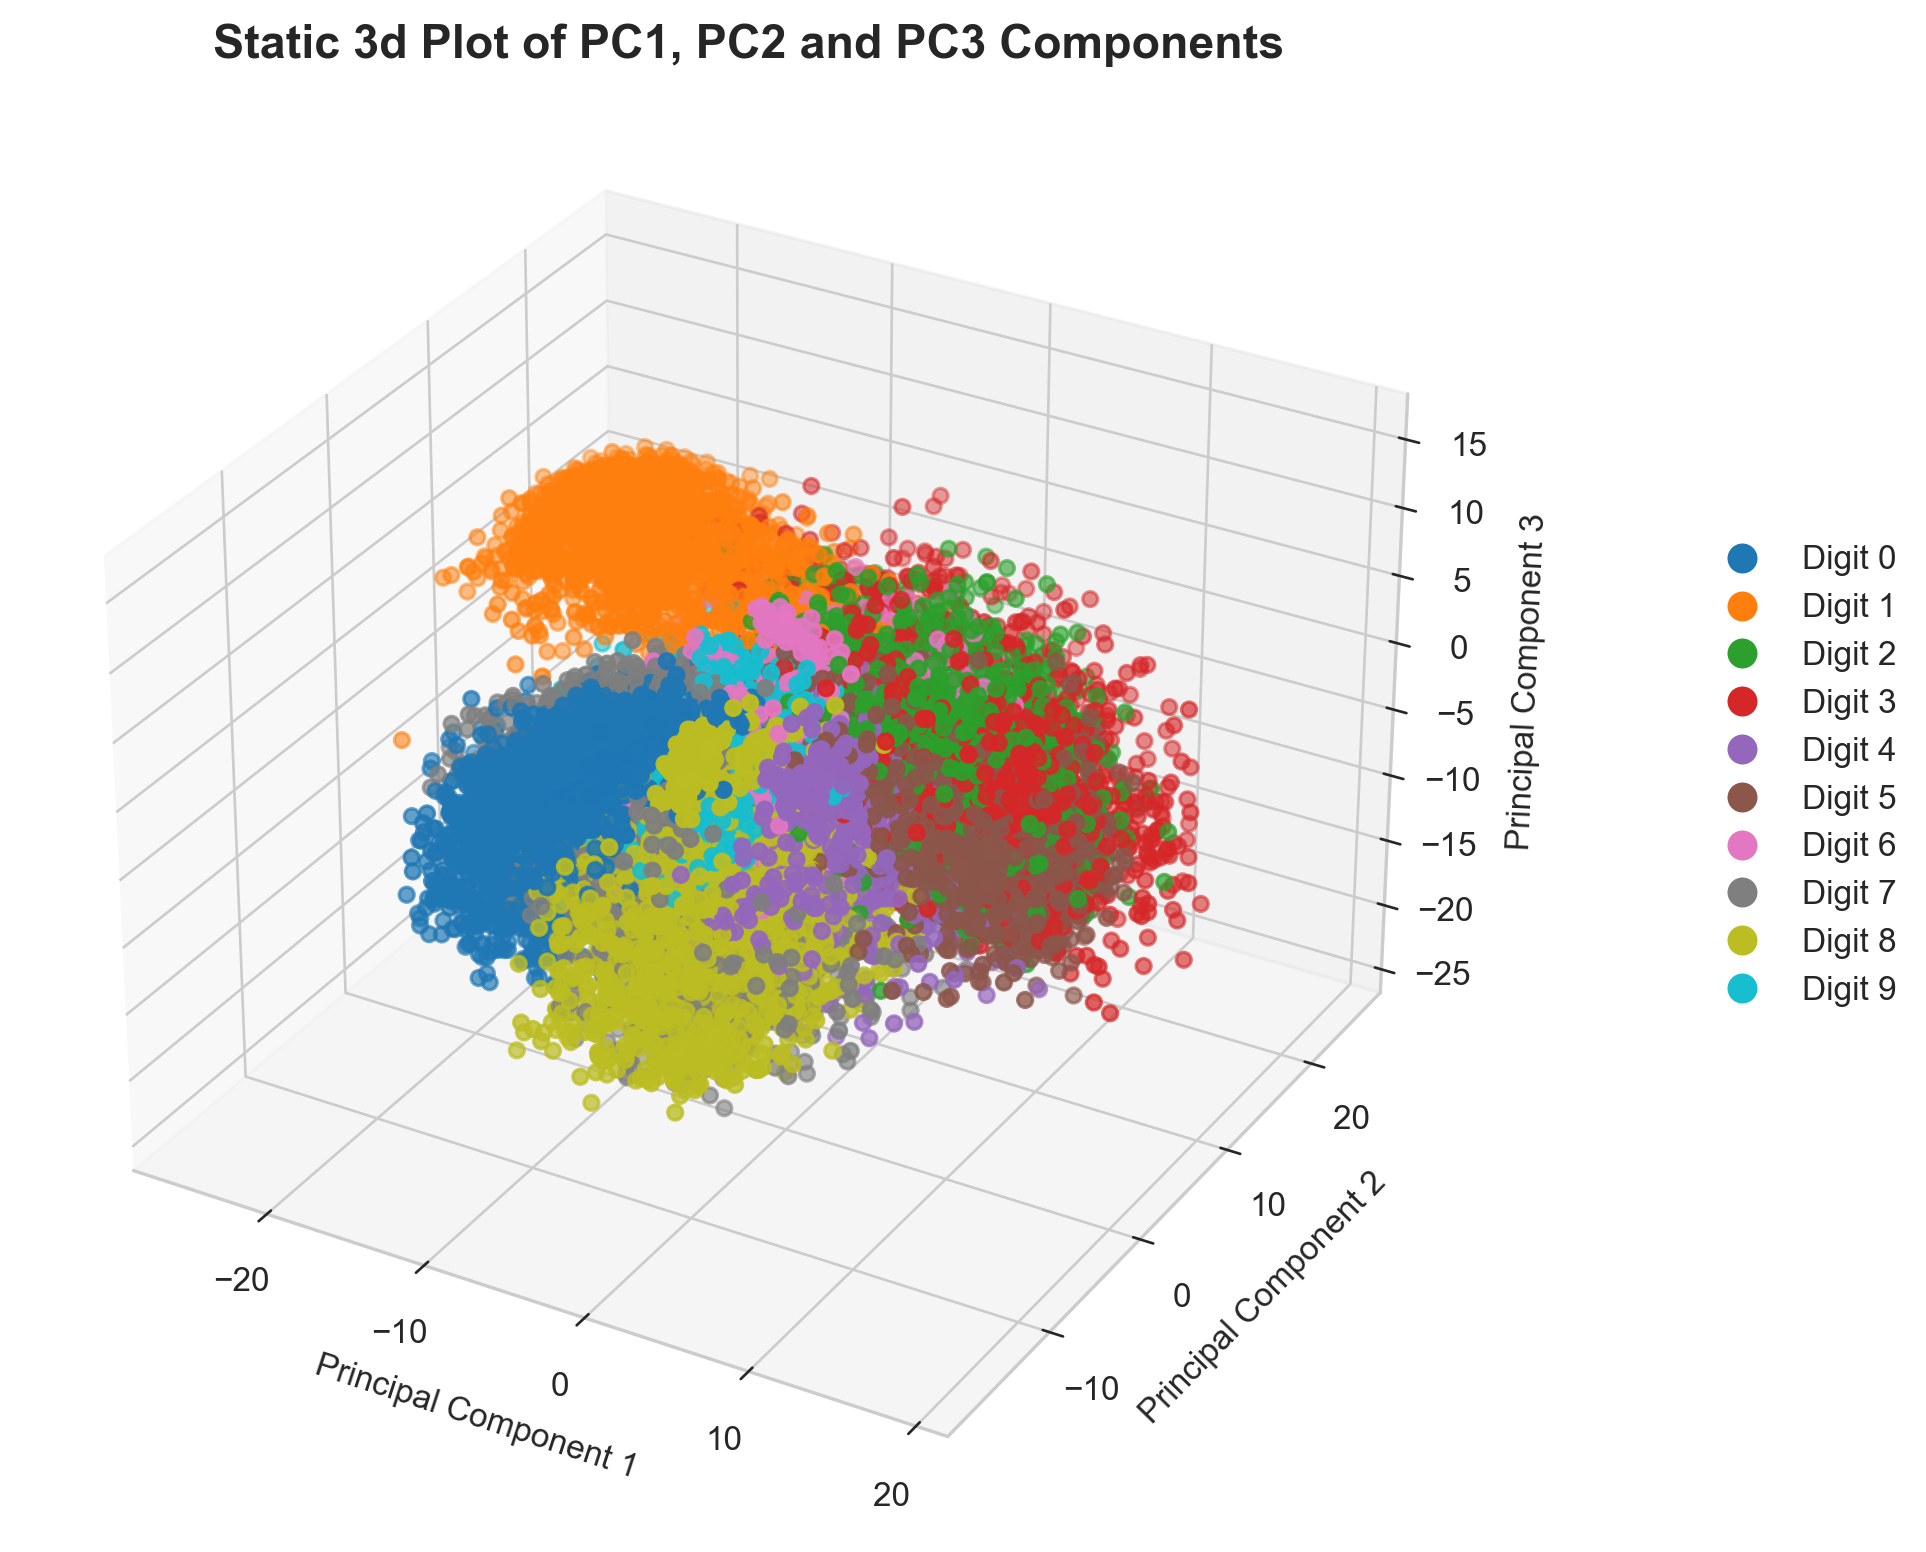

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8), dpi = 240)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=colors)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i),
                              markerfacecolor=colorz[i], markersize=10) for i in range(10)]
legend = fig.legend(handles=legend_elements, loc='center right')
fig.canvas.draw()
plt.title('Static 3d Plot of PC1, PC2 and PC3 Components', fontdict = {'size': 14, 'weight': 'bold'})

plt.show()

#### 3D Plot for Paper

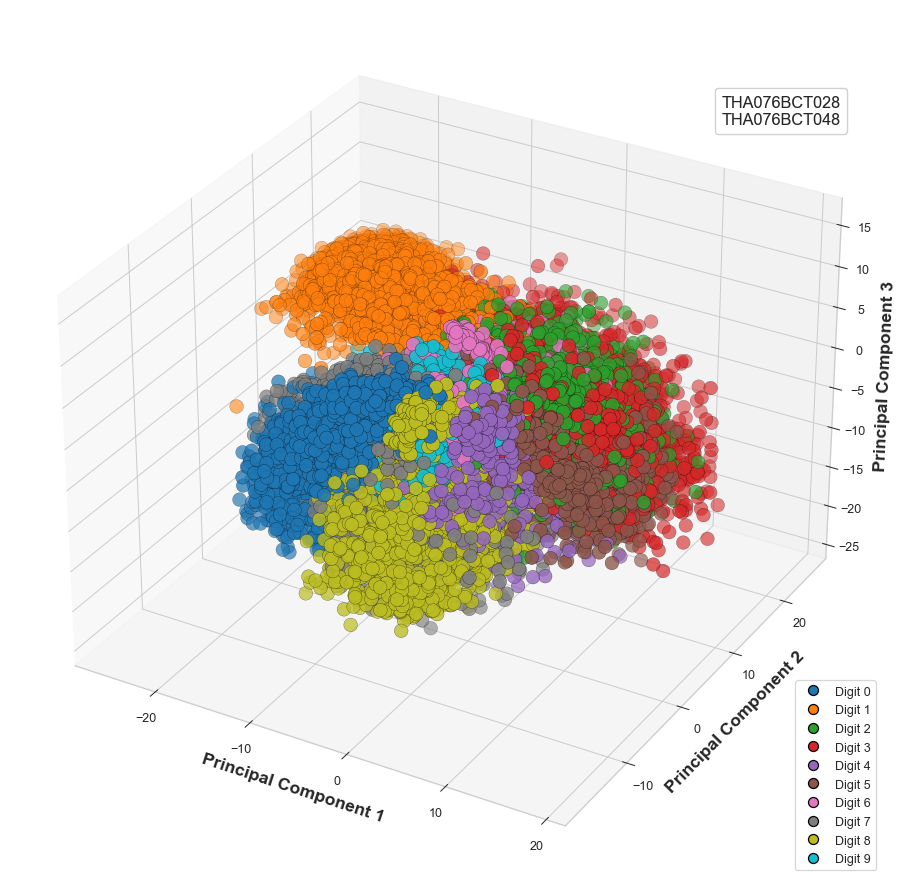

In [461]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10), dpi = 90)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c = colors , linewidths = 0.22, edgecolors=['black'] * len(Y), s = 120)
ax.set_xlabel('Principal Component 1', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
ax.set_ylabel('Principal Component 2', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
ax.set_zlabel('Principal Component 3', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i), markerfacecolor=colorz[i], markersize = 8, linewidth = 0.15, markeredgecolor = 'black') for i in range(10)]
legend = fig.legend(handles = legend_elements, frameon = True, fancybox = True)
legend.set_bbox_to_anchor((0.98, 0.24))

font = FontProperties(family='Arial', size = 13)
name_legend = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop = font, frameon=True)
name_legend.set_bbox_to_anchor((0.95, 0.90))
fig.add_artist(name_legend)

plt.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('./Figures/PC1 vs PC2 vs PC3 - BEST 3D Plot Example.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### 3D Plot Worst Example between: PC90, PC91, PC92

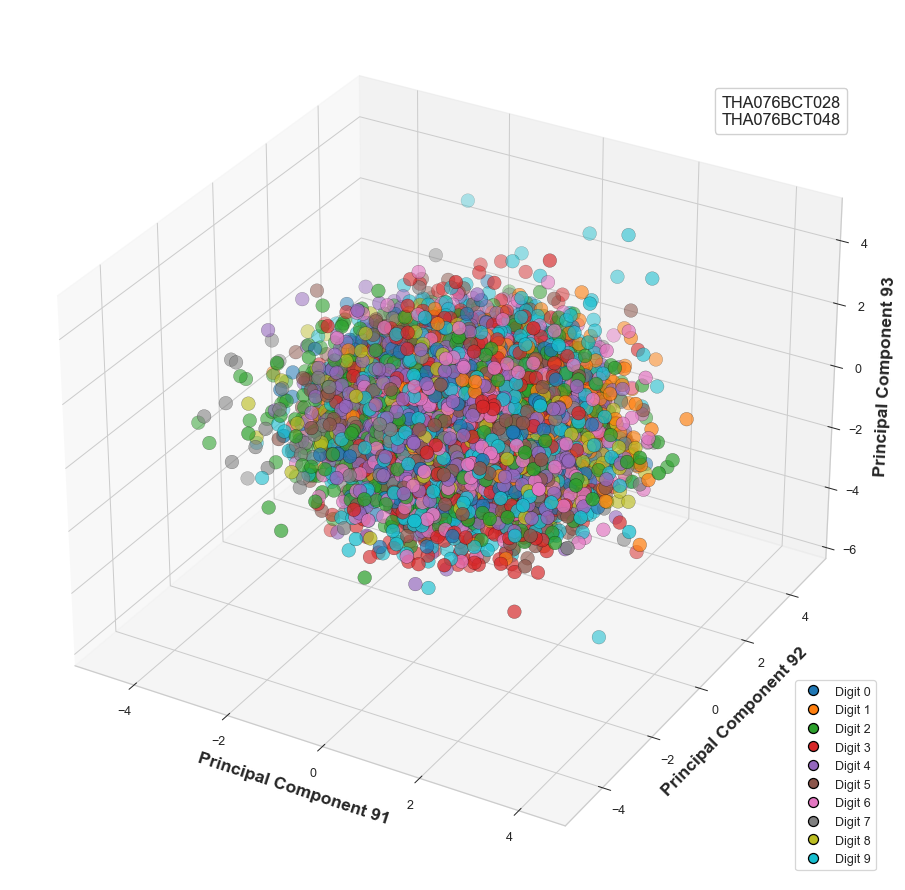

In [462]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10), dpi = 90)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Y[:, 90], Y[:, 91], Y[:, 92], c = colors , linewidths = 0.22, edgecolors=['black'] * len(Y), s = 120)
ax.set_xlabel('Principal Component 91', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
ax.set_ylabel('Principal Component 92', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})
ax.set_zlabel('Principal Component 93', fontdict = {'family' : 'Arial', 'weight':'bold', 'size': 14})

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Digit ' + str(i), markerfacecolor=colorz[i], markersize = 8, linewidth = 0.15, markeredgecolor = 'black') for i in range(10)]
legend = fig.legend(handles = legend_elements, frameon = True, fancybox = True)
legend.set_bbox_to_anchor((0.98, 0.24))

font = FontProperties(family='Arial', size = 13)
name_legend = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop = font, frameon=True)
name_legend.set_bbox_to_anchor((0.95, 0.90))
fig.add_artist(name_legend)

plt.grid(color='gray', linestyle='--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('./Figures/PC91 vs PC92 vs PC93 - WORST 3D Plot Example.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Interactive 3d Plot

In [464]:
import plotly.graph_objects as go

# Map colors to digits
digit_colors = [colorz[int(i.split("_")[-1])] for i in y_train_target]

fig = go.Figure()

# Add main scatter plot
fig.add_trace(go.Scatter3d(
    x=Y[:, 0],
    y=Y[:, 1],
    z=Y[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color = digit_colors,
        opacity = 0.8
    ),
    showlegend=False
))

# Add legend items
for i in range(10):
    fig.add_trace(go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=dict(
            size = 20,
            color = colorz[i],
            opacity = 1.0
        ),
        name = str(i)
    ))

fig.update_layout(
    title='Interactive 3D Scatter Plot of PC1, PC2 and PC3 Components',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    showlegend=True
)

fig.show()

#### Analysis: (UJJWAL MAKE AMENDS)
1. 

In [60]:
Y = PCA_m(4)

In [61]:
pairplot_df = pd.DataFrame(Y, columns=['Principal Component '+str(j) for j in range(Y.shape[1])])
pairplot_df.reindex(pairplot_df.columns.sort_values(ascending=True))
z_columns = pairplot_df.columns

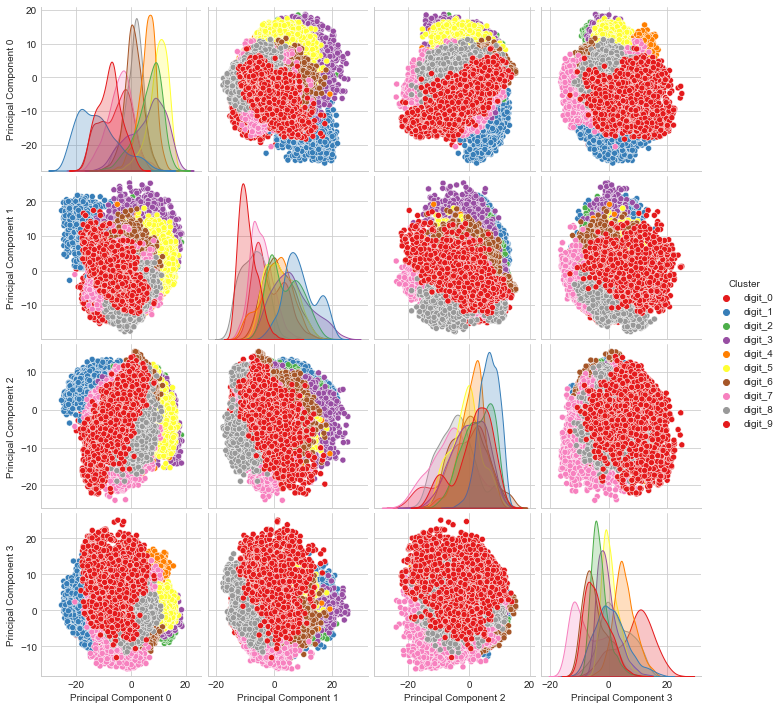

In [62]:
pairplot_df['Cluster'] = y_train_target
pairplot_df = pairplot_df.sort_values('Cluster',ascending=True)
sns.pairplot(pairplot_df, hue='Cluster', 
             vars=z_columns, # don't plot the category/system response
             palette='Set1')
plt.show()

#### Analysis:
1. UJJWAL WRITE SOME HUTITAU SUTFF.<br>
<br>
How do we interpret this plot?

First, it's a pleasant surprises that even with a measly four principal components, the various points corresponding to various digits still cluster nicely - in some data sets, this is not so clear. The location of these points will compose a probability density function, which could be combined with probabilistic methods to produce a prediction of what digit a point comes from based on where it is located.

The unfortunate thing about the plot is that the clusters are sitting on top of one another. More principal components, or other clustering techniques, can further differentiate these points, but with only four principal components, the explained variance is not high enough to segregate the clusters further.

### Reconstrunction Error and Back-Projection

In [465]:
def get_Back_projected_image(n_components, img_index):
#     First n Components
    transformation_matrix = get_n_principal_components(n_components)
    X_digit_1 = X_train_input.iloc[img_index]
    Y_digit_1 = np.dot(transformation_matrix, X_digit_1.T)
    back_projected_img = np.dot(transformation_matrix.T, Y_digit_1)
    return back_projected_img

#     print("Transformation Matrix Shape: ", transformation_matrix.shape)
#     print("Before Transformation (Shape): ", X_digit_1.shape)
#     print("After Transformation (Shape): ", Y_digit_1.shape)
#     print("Back-Projected Shape: ", Xhat_digit_1.shape)

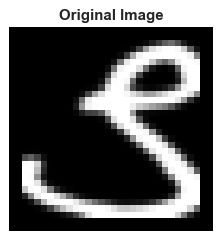

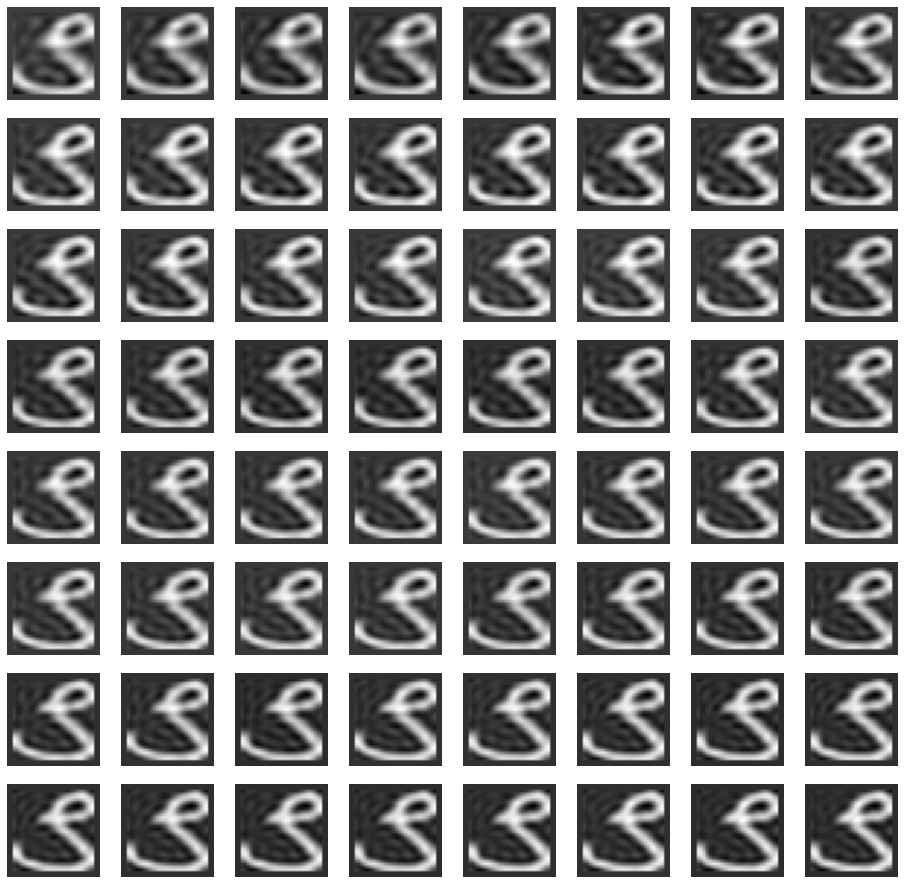

In [466]:
img_index = random.randint(1, len(X_train_input))
plt.figure(figsize = (3, 3), dpi = 90)
plt.axis('off')
plt.grid(False)
plt.title('Original Image', fontdict = {'size' : 12, 'weight' : 'bold'})
plt.imshow(X_train_input.iloc[img_index].to_numpy().reshape(32, 32), cmap = 'gray')

plt.figure(figsize=(16, 16))
for i in range(65, 129, 1):
    bp_image = get_Back_projected_image(i, img_index)
    plt.subplot(8, 8, i - 64)
    plt.imshow(bp_image.reshape(32, 32), cmap = 'gray')
    plt.grid(False)
    plt.axis('off')

#### Plot from a given list of [Components]

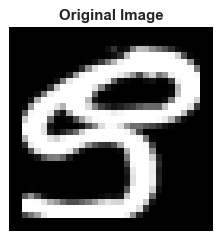

In [480]:
img_index = random.randint(1, len(X_train_input))
plt.figure(figsize = (3, 3), dpi = 90)
plt.axis('off')
plt.grid(False)
plt.title('Original Image', fontdict = {'size' : 12, 'weight' : 'bold'})
plt.imshow(X_train_input.iloc[img_index].to_numpy().reshape(32, 32), cmap = 'gray')
plt.show()

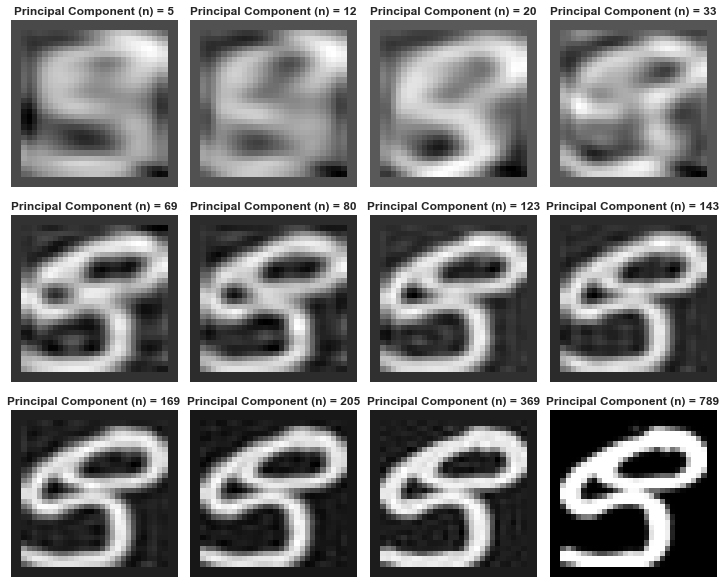

In [484]:
component_list = [5, 12, 20, 33, 69, 80, 123, 143, 169, 205, 369, 789]
len_cm_list = len(component_list)
num_rows = int(len_cm_list ** 0.5)
num_columns = int((len_cm_list + num_rows - 1) // num_rows)

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.01, right=0.99, bottom = 0.01, top = 0.82, wspace=0.08, hspace=0.01)
for i, component in enumerate(component_list):
    bp_image = get_Back_projected_image(component, img_index)
    plt.subplot(num_rows, num_columns, i + 1)
    plt.title(f'Principal Component (n) = {component}', fontdict = {'size':12, 'weight':'bold'})
    plt.imshow(bp_image.reshape(32, 32), cmap = 'gray')
    plt.grid(False)
    plt.axis('off')

### For Paper:

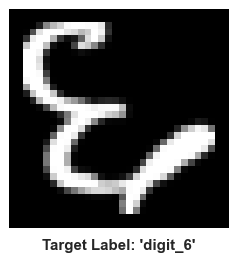

In [587]:
random.seed(131)
img_index = random.randint(1, len(X_train_input))
plt.figure(figsize = (3, 3), dpi = 90)
plt.axis('off')
plt.grid(False)

plt.text(0.5, -0.08, f"Target Label: 'digit_6'", fontsize = 12, weight='bold', ha='center', va='center', transform=plt.gca().transAxes, family='Arial')
plt.imshow(X_train_input.iloc[img_index].to_numpy().reshape(32, 32), cmap = 'gray')

plt.tight_layout()
plt.savefig('./Figures/original_gray_6_image.png', dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()

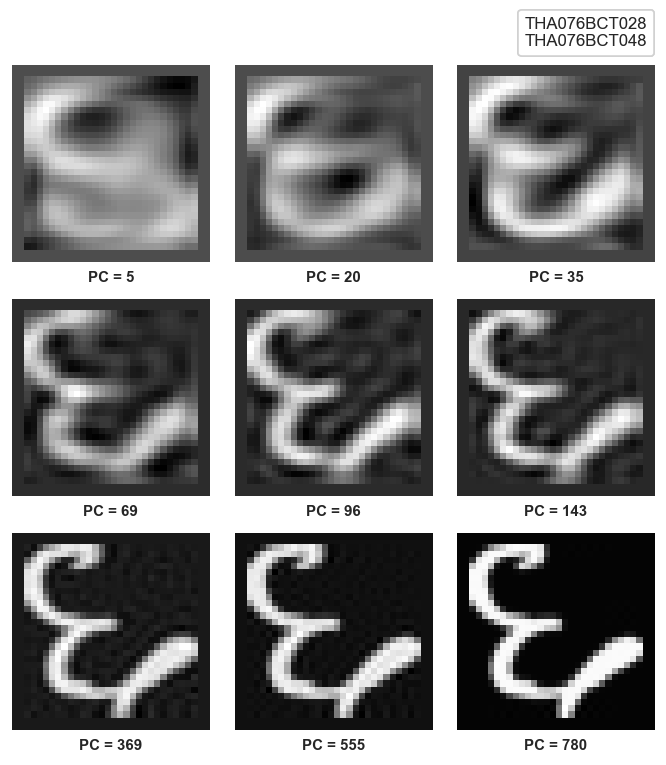

In [589]:
component_list = [5, 20, 35, 69, 96, 143, 369, 555, 780, 369, 789]

len_cm_list = len(component_list)
num_rows = int(len_cm_list ** 0.5)
num_columns = int((len_cm_list + num_rows - 1) // num_rows)

fig = plt.figure(figsize = (6, 6), dpi = 120)
plt.subplots_adjust(left=0.01, right=0.80, bottom = 0.10, top = 0.80, wspace=0.0001, hspace=0.12)
axes = [fig.add_subplot(330 + i + 1) for i in range(9)]

for i, ax in enumerate(axes):
    bp_image = get_Back_projected_image(component_list[i], img_index)
    ax.imshow(bp_image.reshape(32, 32), cmap = 'gray')
    
    ax.grid(False)
    ax.axis('off')
    
    title = f"PC = {component_list[i]}"
    ax.text(0.5, -0.1, title, fontsize = 9, weight = 'bold', ha = 'center', transform = ax.transAxes, family = 'Arial')

    
font = FontProperties(family='Arial', size = 10)
name_legend = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')],
                         ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0,
                         fancybox=True, prop = font, frameon=True)
name_legend.set_bbox_to_anchor((0.92, 1.06))
fig.add_artist(name_legend)

plt.tight_layout()
plt.savefig('./Figures/Multiple_PCS_of_Origianl_Image.png', dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()

#### Analysis:
1. This back-projection demonstrates suitable principal components, which could back-project the reduced dimension back to similar original image. 

#### Assessing PCA Model with MSE

In [590]:
transformation_matrix = get_n_principal_components(5)
transformed_Y = np.dot(transformation_matrix, scaled_X_train.T)
back_projected_X = np.dot(transformation_matrix.T, transformed_Y)

In [591]:
mse = ((back_projected_X.T - scaled_X_train) ** 2).mean(axis = None)
print(mse)
print(1 - mse)

0.5252191336783266
0.4747808663216734


1 - MSE (R-Squared) ranges from 0 to 1, where 0 indicates that the model explains none of the variance in the target variable, and 1 indicates that the model explains all the variance. 

In [470]:
def PCA_MSE(num_component):
    transformation_matrix = get_n_principal_components(num_component)
    transformed_Y = np.dot(transformation_matrix, scaled_X_train.T)
    back_projected_X = np.dot(transformation_matrix.T, transformed_Y)
    mse = ((back_projected_X.T - scaled_X_train) ** 2).mean(axis = None)
    return mse

In [472]:
MSEs = []
N = 80
for i in range(1, N):
    m = PCA_MSE(i)
    MSEs.append((i, m))
    print(f"{i} - Component PCA: MSE = {m:.4f}, R-Squared = {1 - m:.4f}")
MSEs = np.array(MSEs)

1 - Component PCA: MSE = 0.6962, R-Squared = 0.3038
2 - Component PCA: MSE = 0.6417, R-Squared = 0.3583
3 - Component PCA: MSE = 0.5999, R-Squared = 0.4001
4 - Component PCA: MSE = 0.5595, R-Squared = 0.4405
5 - Component PCA: MSE = 0.5252, R-Squared = 0.4748
6 - Component PCA: MSE = 0.4940, R-Squared = 0.5060
7 - Component PCA: MSE = 0.4730, R-Squared = 0.5270
8 - Component PCA: MSE = 0.4534, R-Squared = 0.5466
9 - Component PCA: MSE = 0.4338, R-Squared = 0.5662
10 - Component PCA: MSE = 0.4162, R-Squared = 0.5838
11 - Component PCA: MSE = 0.3997, R-Squared = 0.6003
12 - Component PCA: MSE = 0.3840, R-Squared = 0.6160
13 - Component PCA: MSE = 0.3698, R-Squared = 0.6302
14 - Component PCA: MSE = 0.3571, R-Squared = 0.6429
15 - Component PCA: MSE = 0.3445, R-Squared = 0.6555
16 - Component PCA: MSE = 0.3330, R-Squared = 0.6670
17 - Component PCA: MSE = 0.3226, R-Squared = 0.6774
18 - Component PCA: MSE = 0.3127, R-Squared = 0.6873
19 - Component PCA: MSE = 0.3031, R-Squared = 0.6969
20

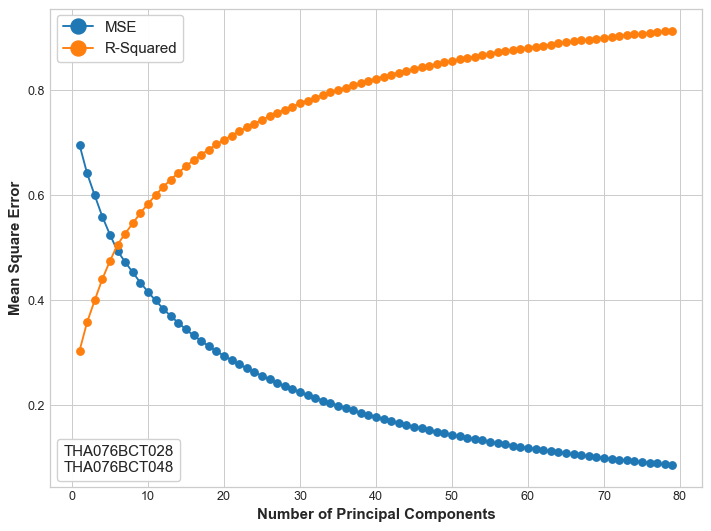

In [636]:
fig = plt.figure(figsize = (8, 6), dpi = 90)
plt.plot(MSEs[:,0], MSEs[:,1],'-o',label='MSE')
plt.plot(MSEs[:,0], 1.0 - MSEs[:,1],'-o',label='R-Squared')

# plt.title('Mean Square Error, Principal Components Analysis', fontdict = {'size':12, 'weight':"bold"})
plt.xlabel('Number of Principal Components',  fontdict = {'size' : 12, 'weight' : "bold", 'family':'Arial'})
plt.ylabel('Mean Square Error',  fontdict = {'size' : 12, 'weight' : "bold", 'family': 'Arial'})

# Customize the legend
legend = fig.legend(markerscale=2, prop = font, frameon = True)
legend.set_bbox_to_anchor((0.265, 0.97))
fig.add_artist(legend)    

font = FontProperties(family = 'Arial', size = 12)
legend_1 = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((0.26, 0.185))

fig.add_artist(legend_1)
plt.tight_layout()

plt.savefig('./Figures/no_PC vs MSE and R-Squared.png', dpi = 300, bbox_inches = 'tight', transparent = False)
plt.show()

In [477]:
MSEs_ALL = []
N = 500
for i in tqdm(range(1, N)):
    m = PCA_MSE(i)
    MSEs_ALL.append((i, m))
MSEs_ALL = np.array(MSEs_ALL)

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [07:35<00:00,  1.10it/s]


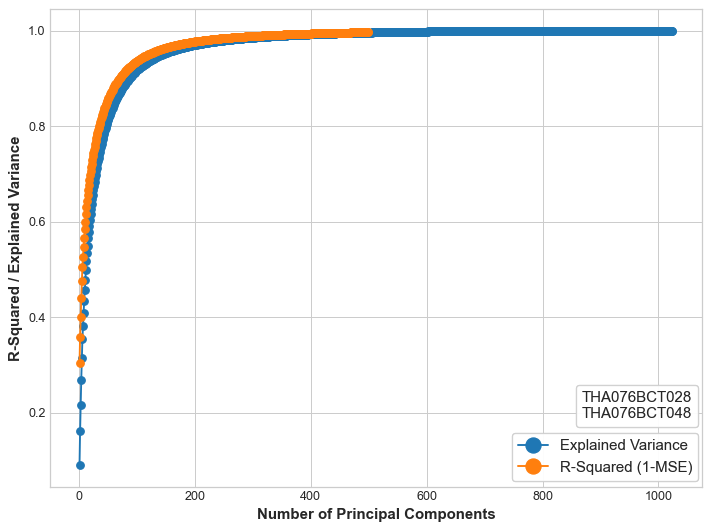

In [653]:
fig = plt.figure(figsize = (8, 6), dpi = 90)
plt.plot(range(1,len(explained_variance)+1), np.cumsum(explained_variance),'-o',label='Explained Variance')
plt.plot(MSEs_ALL[:,0], 1.0 - MSEs_ALL[:,1],'-o',label='R-Squared (1-MSE)')

# plt.title('(1-MSE) versus Explained Variance',  fontdict = {'size':12, 'weight':"bold"})
plt.xlabel('Number of Principal Components',  fontdict = {'size' : 12, 'weight':"bold", 'family':'Arial'})
plt.ylabel('R-Squared / Explained Variance',  fontdict = {'size' : 12, 'weight':"bold", 'family':'Arial'})

# Customize the legend
legend = fig.legend(markerscale=2, prop = font, frameon = True)
legend.set_bbox_to_anchor((0.98, 0.195))
fig.add_artist(legend)    

font = FontProperties(family = 'Arial', size = 12)
legend_1 = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((0.98, 0.285))

fig.add_artist(legend_1)
plt.tight_layout()

plt.savefig('./Figures/R-Squared and Explained Variance vs no_of principal components.png', dpi = 300, bbox_inches = 'tight', transparent = False)

plt.show()

While the values of 1 - MSE differ from the explained variance slightly for the first few principal components, the two values are very close. Because explained variance is the more widely-used metric of error, and is easier to compute, we'd do well to stick with that.

## Multi-Class Classification on Nepali Dataset (Original Dataset)

### Loading Nepali Handwritten Digit Dataset

In [654]:
train_df = pd.read_csv('./Nepali Dataset/train_digits_data.csv')
test_df = pd.read_csv('./Nepali Dataset/test_digits_data.csv')

#### Train CSV - 17000 rows x 1025 columns (label + 32 x 32 pixles)
#### Test CSV -  3000 rows x 1025 columns (label + 32 x 32 pixles) <br>

In [658]:
# Merging train and test MNIST CSV dataset
train_dataset = pd.concat([train_df, test_df], axis = 0, ignore_index = True)
train_dataset.tail(2)

pixel_0000  pixel_0001  pixel_0002  pixel_0003  ...  pixel_1021  \
19998           0           0           0           0  ...           0   
19999           0           0           0           0  ...           0   

       pixel_1022  pixel_1023  character  
19998           0           0    digit_9  
19999           0           0    digit_9  

[2 rows x 1025 columns]

In [659]:
train_dataset['label'] = train_dataset['character'].str.replace('digit_', '').astype(int)
train_dataset = train_dataset.drop('character', axis = 1)
train_dataset.tail(2)

pixel_0000  pixel_0001  pixel_0002  pixel_0003  ...  pixel_1021  \
19998           0           0           0           0  ...           0   
19999           0           0           0           0  ...           0   

       pixel_1022  pixel_1023  label  
19998           0           0      9  
19999           0           0      9  

[2 rows x 1025 columns]

### Dataset Preprocessing and Exploration

In [660]:
y = train_dataset['label']
X = train_dataset.drop('label', axis = 1)

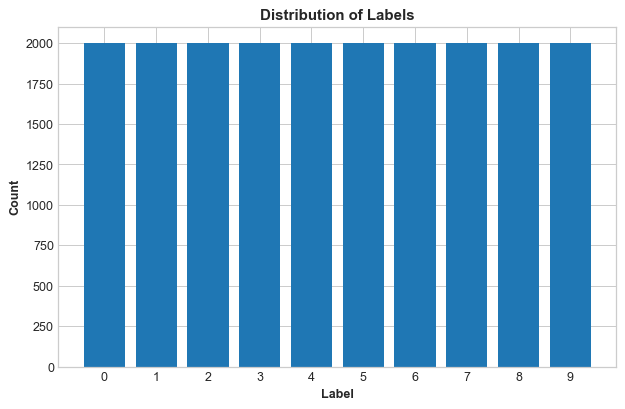

In [661]:
# Count the occurences of each category in the 'label' Column
label_counts = train_dataset['label'].value_counts()

# Get unique labels (class) and their count values
labels = label_counts.index
counts = label_counts.values

# Some Plotting Skills
plt.figure(figsize = (8, 5), dpi = 90)
plt.style.use('seaborn-whitegrid')
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel('Label', fontdict = {'size':10, 'weight':'bold'})
plt.ylabel('Count', fontdict = {'size':10, 'weight':'bold'})
plt.title('Distribution of Labels', fontdict = {'size':12, 'weight':'bold'})
plt.show()

### Split 'train_dataset' into 'train' and 'test' dataset

In [662]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 69)

In [663]:
print("'X_train' Size(rows): ", len(X_train))
print("'y_train' Size(rows): ", len(y_train))
print("'X_test' Size(rows): ", len(X_test))
print("'y_test' Size(rows): ", len(y_test))

'X_train' Size(rows):  16000
'y_train' Size(rows):  16000
'X_test' Size(rows):  4000
'y_test' Size(rows):  4000


### Classification Models
#### Logistic Regression
#### On Original Dataset

#### Feature Scaling

In [664]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Training Logistic Regression

In [665]:
# setting a specific value for 'random_state' ensues that the logistic regression model's random initialization and shuffling of data points remains the same across different runs
# 'max_iter' determines the maximum number of iterations (epochs) that the model will perform to optimize the model's parameter
lr_classifier = LogisticRegression(random_state = 69, max_iter = 1500)
lr_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1500, random_state=69)

In [666]:
X_test_scaled = scaler.transform(X_test)

In [667]:
y_pred = lr_classifier.predict(X_test_scaled)

In [668]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Accuracy: 94.17%


In [669]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       394
           1       0.99      0.98      0.98       411
           2       0.86      0.88      0.87       404
           3       0.87      0.85      0.86       380
           4       0.95      0.94      0.94       400
           5       0.96      0.96      0.96       424
           6       0.96      0.92      0.94       419
           7       0.93      0.95      0.94       390
           8       0.97      0.98      0.98       390
           9       0.97      0.96      0.97       388

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



In [673]:
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extract relevant data from the classification report
data = []

for key, value in classification_rep.items():
    if key not in ['accuracy', 'macro avg', 'weighted avg']:
        row = [key] + [value[label] for label in value.keys()]
        data.append(row)
# Create DataFrame from the extracted data
columns = ['class', 'precision', 'recall', 'f1-score', 'support']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
df.to_excel('classification_report_best.xlsx', index=True)

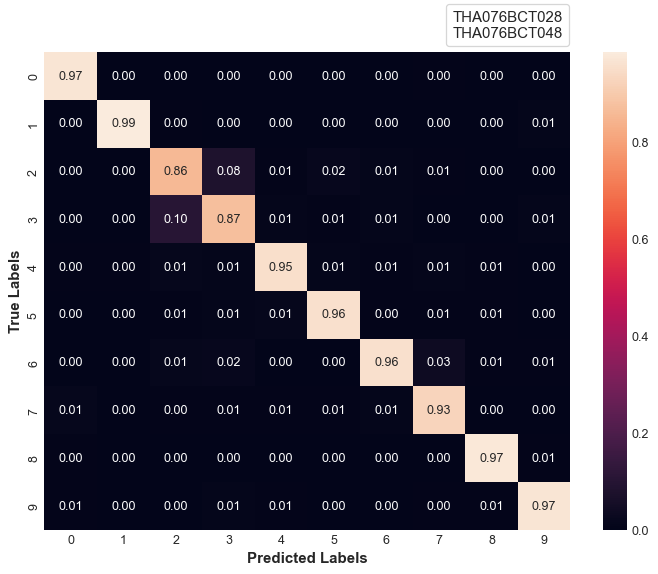

In [687]:
cm = confusion_matrix(y_test, y_pred)

# Calculate row sums
row_sums = cm.sum(axis=0)

# Divide each row by its sum (row normalization)
normalized_cm = cm / row_sums[np.newaxis, :]

fig = plt.figure(figsize = (8, 6), dpi = 90)
sns.heatmap(normalized_cm, annot=True, fmt='.2f')
plt.xlabel('Predicted Labels',  fontdict = {'size':12, 'weight':'bold'})
plt.ylabel('True Labels',  fontdict = {'size':12, 'weight':'bold'})
# plt.title('Confusion Matrix',  fontdict = {'size':12, 'weight':'bold'})

font = FontProperties(family = 'Arial', size = 12)
legend_1 = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((0.80, 1.07))

plt.tight_layout()

plt.savefig('./Figures/CM_LR_Classifier_ORIGINAL.png', dpi = 300, bbox_inches = 'tight')
plt.show()

The above logistic regression on original full features (1024) pixel element gives an accuracy of 94.17%. <br>
Now, by reducing the original dataset to different Principal Component, the effect on accuracy will be observed. 

#### Apply PCA on X_train

In [688]:
X_train_cov = np.cov(X_train_scaled.T)
X_train_egnvalues, X_train_egnvectors = eigh(X_train_cov)

In [689]:
sorted_index = np.argsort(np.abs(X_train_egnvalues))[::-1]
X_train_egnvalues = np.abs(X_train_egnvalues)[sorted_index]
X_train_egnvectors = X_train_egnvectors.T[sorted_index] # The transposed act

In [270]:
lr_classifier = LogisticRegression(random_state = 69, max_iter = 1500)

def run_exp(no_components):
    transformation_matrix = X_train_egnvectors[:no_components]
    transformed_Y = np.dot(transformation_matrix, X_train_scaled.T)
    Y = transformed_Y.T

    # Fitting Logistic Regression model on Transformed component feature space (of no_components)
    lr_classifier.fit(Y, y_train)
    
    transformed_X_test = np.dot(transformation_matrix, X_test_scaled.T).T
    y_pred = lr_classifier.predict(transformed_X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f"{no_components} Components => Accuracy: {accuracy:.2f}%")
#     return no_components, accuracy

In [272]:
component_list = [5, 12, 20, 33, 69, 80, 123, 143, 169, 205, 369, 789]
for component in range(1, 20, 1):
    run_exp(component)

1 Components => Accuracy: 30.48%
2 Components => Accuracy: 44.32%
3 Components => Accuracy: 52.78%
4 Components => Accuracy: 63.45%
5 Components => Accuracy: 69.15%
6 Components => Accuracy: 75.55%
7 Components => Accuracy: 78.10%
8 Components => Accuracy: 81.73%
9 Components => Accuracy: 83.30%
10 Components => Accuracy: 84.12%
11 Components => Accuracy: 85.75%
12 Components => Accuracy: 86.50%
13 Components => Accuracy: 87.15%
14 Components => Accuracy: 87.40%
15 Components => Accuracy: 88.85%
16 Components => Accuracy: 89.90%
17 Components => Accuracy: 90.30%
18 Components => Accuracy: 90.80%
19 Components => Accuracy: 90.88%


In [690]:
df = pd.read_csv('n_component_vs_accuracy_100.csv')

In [692]:
df = df[['no_components', 'accuracy']]

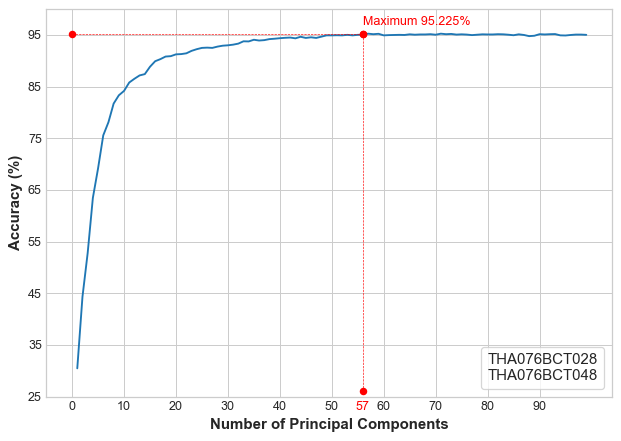

In [774]:
fig = plt.figure(figsize = (7, 5), dpi = 90)

plt.plot(df['no_components'], df['accuracy'])

maxm_acc_index = np.argmax(df['accuracy'].to_numpy())
maximum_acc = df['accuracy'][maxm_acc_index]

x_pt = maxm_acc_index
y_pt = maximum_acc
plt.plot([0, x_pt], [y_pt, y_pt], linestyle='--', marker='o', color = 'red', linewidth = 0.5, markeredgewidth = 0)

plt.plot([x_pt, x_pt], [26, y_pt], linestyle='--', marker='o', color = 'red', linewidth = 0.5, markeredgewidth = 0)
plt.text(54.5, 22.5, f'{maxm_acc_index + 1}', color = 'red')
plt.text(56, 97, f'Maximum {maximum_acc}%', color = 'red')

plt.xlabel("Number of Principal Components", fontdict = {'size' : 12, 'weight' : 'bold'})
plt.ylabel("Accuracy (%)", fontdict = {'size' : 12, 'weight' : 'bold'})
plt.xticks(np.arange(0, 100, 10))
plt.yticks(np.arange(25, 100, 10))
plt.ylim(25, 100)

font = FontProperties(family = 'Arial', size = 12)
legend_1 = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((0.97, 0.225))

plt.tight_layout()
# plt.savefig('./Figures/No_PC VS Accuracy.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [777]:
lr_classifier = LogisticRegression(random_state = 69, max_iter = 1500)

transformation_matrix = X_train_egnvectors[:57]
transformed_Y = np.dot(transformation_matrix, X_train_scaled.T)
Y = transformed_Y.T

# Fitting Logistic Regression model on Transformed component feature space (of no_components)
lr_classifier.fit(Y, y_train)

transformed_X_test = np.dot(transformation_matrix, X_test_scaled.T).T
y_pred = lr_classifier.predict(transformed_X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"{57} Components => Accuracy: {accuracy:.3f}%")

57 Components => Accuracy: 95.225%


In [779]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.3f}%")

Accuracy: 95.225%


In [787]:
classification_rep = classification_report(y_test, y_pred, output_dict = True)

# Extract relevant data from the classification report
data = []

for key, value in classification_rep.items():
    if key not in ['accuracy', 'macro avg', 'weighted avg']:
        row = [key] + [value[label] for label in value.keys()]
        data.append(row)
# Create DataFrame from the extracted data
columns = ['class', 'precision', 'recall', 'f1-score', 'support']
df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
# df.to_excel('PC-57-classification_report_best.xlsx', index=True)

In [790]:
print(classification_report(y_test, y_pred, output_dict = False))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       394
           1       0.99      0.99      0.99       411
           2       0.90      0.89      0.90       404
           3       0.91      0.87      0.89       380
           4       0.96      0.95      0.96       400
           5       0.94      0.97      0.96       424
           6       0.94      0.93      0.94       419
           7       0.93      0.97      0.95       390
           8       0.99      0.98      0.99       390
           9       0.97      0.98      0.97       388

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



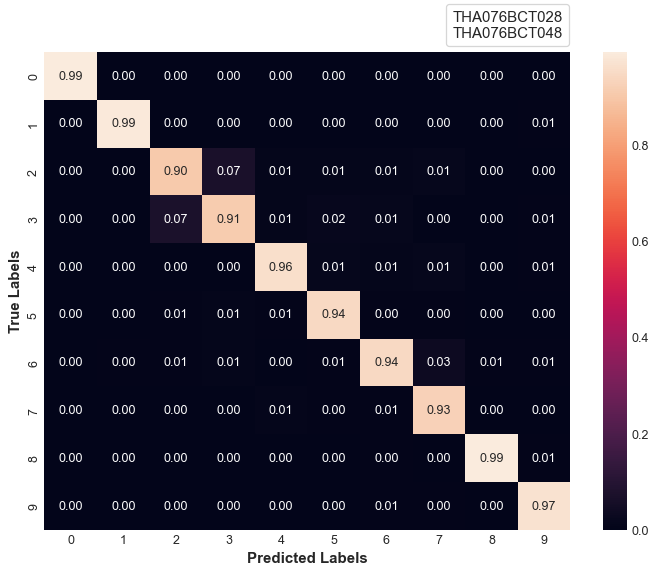

In [791]:
cm = confusion_matrix(y_test, y_pred)

# Calculate row sums
row_sums = cm.sum(axis=0)

# Divide each row by its sum (row normalization)
normalized_cm = cm / row_sums[np.newaxis, :]

fig = plt.figure(figsize = (8, 6), dpi = 90)
sns.heatmap(normalized_cm, annot=True, fmt='.2f')
plt.xlabel('Predicted Labels',  fontdict = {'size':12, 'weight':'bold'})
plt.ylabel('True Labels',  fontdict = {'size':12, 'weight':'bold'})
# plt.title('Confusion Matrix',  fontdict = {'size':12, 'weight':'bold'})

font = FontProperties(family = 'Arial', size = 12)
legend_1 = fig.legend([plt.Line2D([], [], linestyle='none', marker=None, color='none')], ['THA076BCT028\nTHA076BCT048'], handlelength=0, handletextpad=0, fancybox=True, prop=font, frameon = True)
legend_1.set_bbox_to_anchor((0.80, 1.07))

plt.tight_layout()

# plt.savefig('./Figures/Confusion Matrix PC.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
def run_exp(no_components):
    scaled_Y = eigenvectors[:no_components] @ scaled_X_train.T
    Y = scaled_Y.T
    new_df = pd.DataFrame(Y)
    new_df['label'] = y_train_target
    y = new_df['label']
    X = new_df.drop('label', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 69)
    lr_classifier = LogisticRegression(random_state = 69, max_iter = 1000)
    lr_classifier.fit(X_train, y_train)
    y_pred = lr_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f"{no_components} Components => Accuracy: {accuracy:.2f}%")
    return no_components, accuracy

In [ ]:
exp_data = []
for i in range(1, 50, 2):
    exp_data.append(run_exp(i))

In [ ]:
compressed_output = Y[0].reshape(28, 28)

plt.imshow(compressed_output, cmap = 'gray')
plt.title(f'Target Label: {y_train_target[0]}')
plt.axis('off')
plt.show()